In [ ]:
pip install scorecardpy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,make_scorer,fbeta_score
import scorecardpy as sc
import pprint
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import statsmodels.api as sm

# Represent data in standard decimal notation
pd.options.display.float_format = '{:.2f}'.format

file destination to be changed before submission,
rmb to test!!

# Loading Data From CSV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load CSV from Google Drive
application_data = pd.read_csv('/content/drive/My Drive/Y3 S2/FA/fa g3-4/IS453 Group Assignment - Application Data.csv')
# application_data = pd.read_csv('/content/drive/MyDrive/FA/fa g3-4/IS453 Group Assignment - Application Data.csv')
application_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 119 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(62), int64(41), object(16)
memory usage: 279.2+ MB


In [ ]:
bureau_data = pd.read_csv("/content/drive/My Drive/Y3 S2/FA/fa g3-4/IS453 Group Assignment - Bureau Data.csv")
# bureau_data = pd.read_csv("/content/drive/My Drive/FA/fa g3-4/IS453 Group Assignment - Bureau Data.csv")
bureau_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


# Extracting the selected columns

In [ ]:
selected_application_col = ["SK_ID_CURR",
                    "TARGET",
                    "AMT_ANNUITY",
                    "FLAG_OWN_CAR",
                    "FLAG_OWN_REALTY",
                    "AMT_INCOME_TOTAL",
                    "AMT_CREDIT",
                    "AMT_GOODS_PRICE",
                    "NAME_EDUCATION_TYPE",
                    "NAME_FAMILY_STATUS",
                    "NAME_HOUSING_TYPE",
                    "DAYS_BIRTH",
                    "DAYS_EMPLOYED",
                    "FLAG_CONT_MOBILE",
                    "OCCUPATION_TYPE",
                    "CNT_FAM_MEMBERS",
                    "REGION_RATING_CLIENT_W_CITY",
                    "REG_CITY_NOT_LIVE_CITY",
                    ]

filtered_application_data = application_data[selected_application_col]
filtered_application_data.info()

# check if a loan can have multiple rows of application data
unique_id_count1 = filtered_application_data['SK_ID_CURR'].nunique()
print("number of unique id in application data:", unique_id_count1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   AMT_ANNUITY                  307499 non-null  float64
 3   FLAG_OWN_CAR                 307511 non-null  object 
 4   FLAG_OWN_REALTY              307511 non-null  object 
 5   AMT_INCOME_TOTAL             307511 non-null  float64
 6   AMT_CREDIT                   307511 non-null  float64
 7   AMT_GOODS_PRICE              307233 non-null  float64
 8   NAME_EDUCATION_TYPE          307511 non-null  object 
 9   NAME_FAMILY_STATUS           307511 non-null  object 
 10  NAME_HOUSING_TYPE            307511 non-null  object 
 11  DAYS_BIRTH                   307511 non-null  int64  
 12  DAYS_EMPLOYED                307511 non-null  int64  
 13 

In [ ]:
selected_bureau_col = ["SK_ID_CURR",
                        "CNT_CREDIT_PROLONG",
                        "AMT_CREDIT_SUM_OVERDUE",
                        "CREDIT_ACTIVE",
                        "CREDIT_DAY_OVERDUE",
                        "AMT_CREDIT_MAX_OVERDUE"
                       ]
filtered_bureau_data = bureau_data[selected_bureau_col]
filtered_bureau_data.info()

# check if a loan can have multiple rows of bureau data
unique_id_count2 = filtered_bureau_data['SK_ID_CURR'].nunique()
print("number of unique id in bureau data:", unique_id_count2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 6 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   CNT_CREDIT_PROLONG      int64  
 2   AMT_CREDIT_SUM_OVERDUE  float64
 3   CREDIT_ACTIVE           object 
 4   CREDIT_DAY_OVERDUE      int64  
 5   AMT_CREDIT_MAX_OVERDUE  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 78.6+ MB
number of unique id in bureau data: 305811


# Data Merging

In [ ]:
# Changing columns in days to years
filtered_application_data['AGE'] = (filtered_application_data['DAYS_BIRTH']/-365).astype(int)
filtered_application_data['YEARS_EMPLOYED'] = (filtered_application_data['DAYS_EMPLOYED']/-365).astype(int)

# Drop days variables
filtered_application_data.drop("DAYS_BIRTH", axis=1, inplace=True)
filtered_application_data.drop("DAYS_EMPLOYED", axis=1, inplace=True)

In [ ]:
# Group by SK_ID_CURR and compute the mean for numerical variables
avg_bureau_data = filtered_bureau_data.groupby("SK_ID_CURR").agg({
    "CNT_CREDIT_PROLONG": "mean",
    "AMT_CREDIT_SUM_OVERDUE": "mean",
    "CREDIT_DAY_OVERDUE": "mean",
    "AMT_CREDIT_MAX_OVERDUE":"mean"
}).reset_index()

# Rename columns
avg_bureau_data.rename(columns={
    "CNT_CREDIT_PROLONG": "AVG_CNT_CREDIT_PROLONG",
    "AMT_CREDIT_SUM_OVERDUE": "AVG_AMT_CREDIT_SUM_OVERDUE",
    "CREDIT_DAY_OVERDUE": "AVG_CREDIT_DAY_OVERDUE",
    "AMT_CREDIT_MAX_OVERDUE":"AVG_AMT_CREDIT_MAX_OVERDUE"
}, inplace=True)

avg_bureau_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 5 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  305811 non-null  int64  
 1   AVG_CNT_CREDIT_PROLONG      305811 non-null  float64
 2   AVG_AMT_CREDIT_SUM_OVERDUE  305811 non-null  float64
 3   AVG_CREDIT_DAY_OVERDUE      305811 non-null  float64
 4   AVG_AMT_CREDIT_MAX_OVERDUE  212971 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 11.7 MB


array([[<Axes: title={'center': 'SK_ID_CURR'}>,
        <Axes: title={'center': 'AVG_CNT_CREDIT_PROLONG'}>],
       [<Axes: title={'center': 'AVG_AMT_CREDIT_SUM_OVERDUE'}>,
        <Axes: title={'center': 'AVG_CREDIT_DAY_OVERDUE'}>],
       [<Axes: title={'center': 'AVG_AMT_CREDIT_MAX_OVERDUE'}>, <Axes: >]],
      dtype=object)

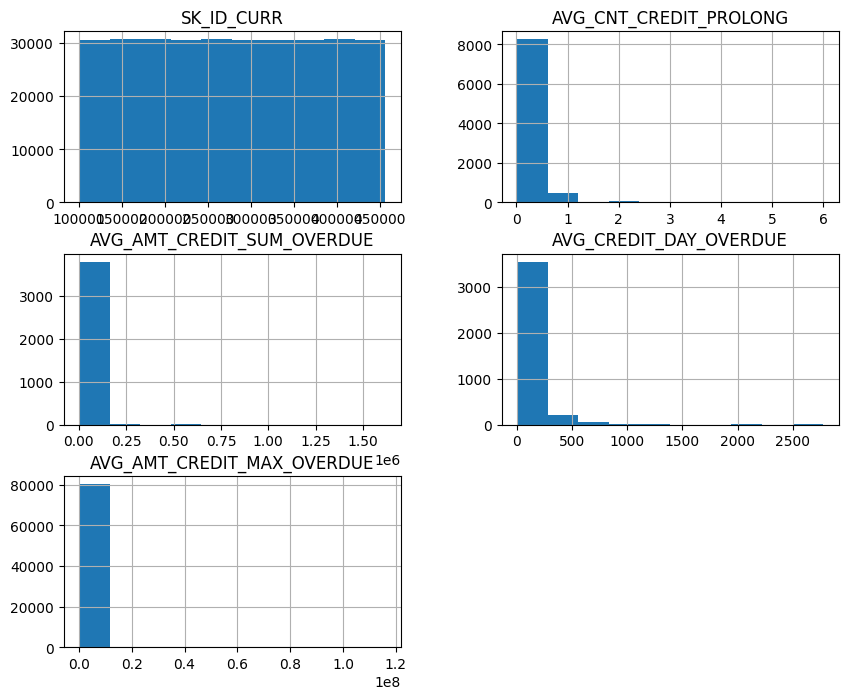

In [ ]:
# # removed 0 from data for visualisation
avg_bureau_data[avg_bureau_data != 0].hist(figsize=(10, 8))


In [ ]:
# Merge application data and bureau data
merged_data = filtered_application_data.merge(avg_bureau_data, how="left", on="SK_ID_CURR")
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   AMT_ANNUITY                  307499 non-null  float64
 3   FLAG_OWN_CAR                 307511 non-null  object 
 4   FLAG_OWN_REALTY              307511 non-null  object 
 5   AMT_INCOME_TOTAL             307511 non-null  float64
 6   AMT_CREDIT                   307511 non-null  float64
 7   AMT_GOODS_PRICE              307233 non-null  float64
 8   NAME_EDUCATION_TYPE          307511 non-null  object 
 9   NAME_FAMILY_STATUS           307511 non-null  object 
 10  NAME_HOUSING_TYPE            307511 non-null  object 
 11  FLAG_CONT_MOBILE             307511 non-null  int64  
 12  OCCUPATION_TYPE              211120 non-null  object 
 13 

# Exploratory Data Analysis (EDA)

## Filter by target group (labourers), age and credit amount

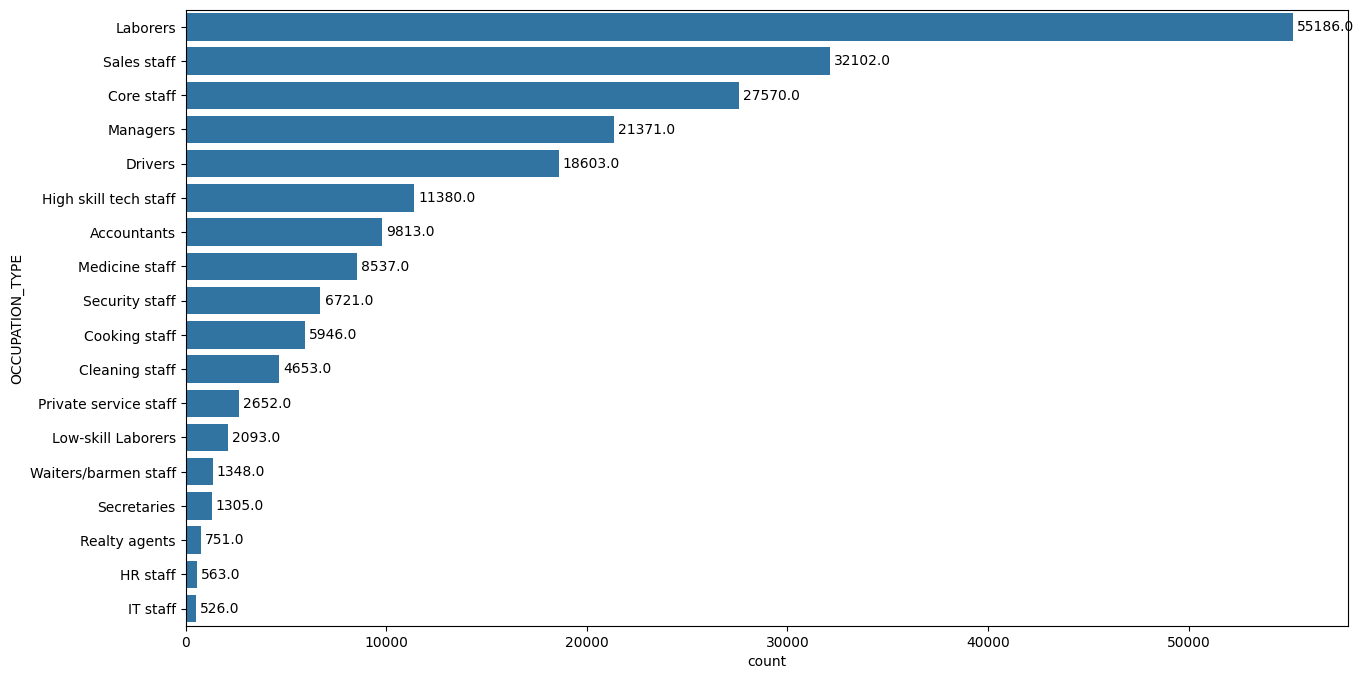

In [ ]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(y='OCCUPATION_TYPE', data=merged_data, order=merged_data['OCCUPATION_TYPE'].value_counts().index)

for rect in ax.patches:
    width = rect.get_width()
    ax.annotate('{}'.format(width), xy=(width, rect.get_y() + rect.get_height() / 2),
                xytext=(3, 0), textcoords="offset points", ha='left', va='center')

plt.show()

In [ ]:
# Replace 'Laborers' and 'Low-skill Laborers' with 'Total Laborers'
merged_data['OCCUPATION_TYPE'] = merged_data['OCCUPATION_TYPE'].replace({
    'Laborers': 'All Laborers',
    'Low-skill Laborers': 'All Laborers'
})
merged_data['OCCUPATION_TYPE']

0         All Laborers
1           Core staff
2         All Laborers
3         All Laborers
4           Core staff
              ...     
307506     Sales staff
307507             NaN
307508        Managers
307509    All Laborers
307510    All Laborers
Name: OCCUPATION_TYPE, Length: 307511, dtype: object

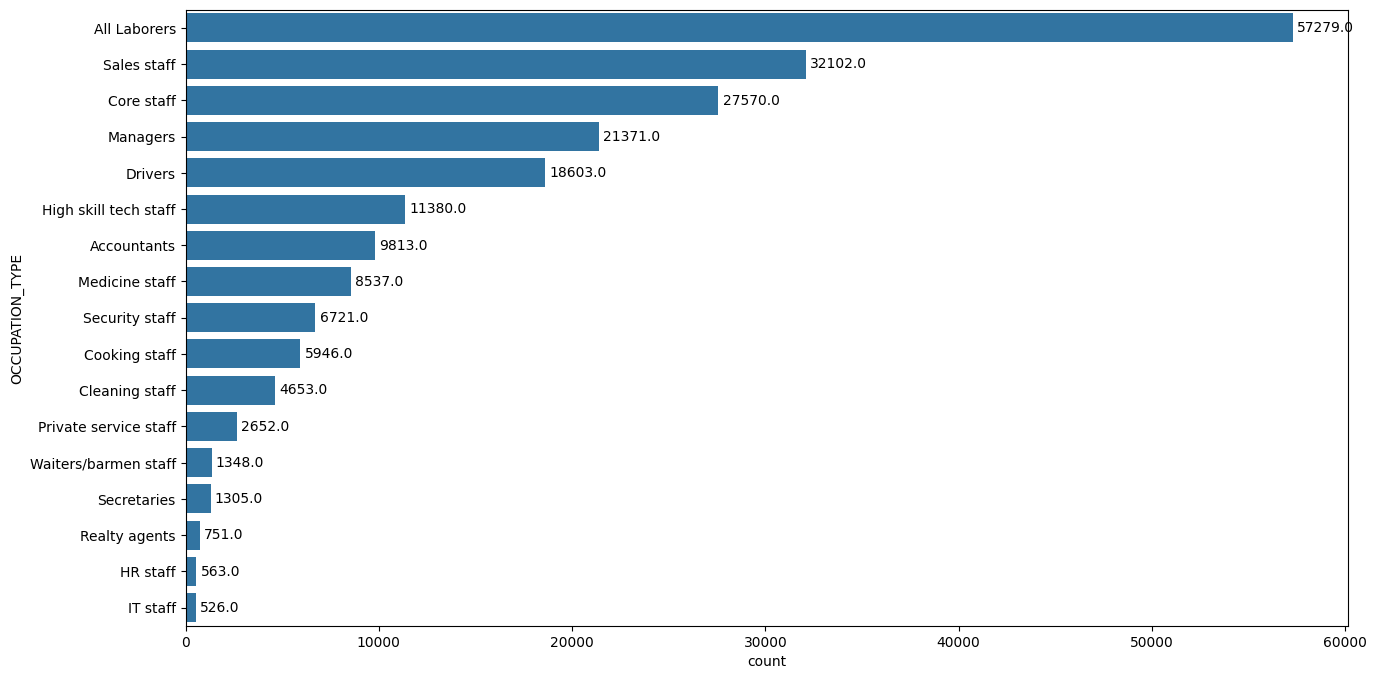

In [ ]:
# Distribution of OCCUPATION_TYPE
plt.figure(figsize=(15, 8))
ax = sns.countplot(y='OCCUPATION_TYPE', data=merged_data, order=merged_data['OCCUPATION_TYPE'].value_counts().index)

for rect in ax.patches:
    width = rect.get_width()
    ax.annotate('{}'.format(width), xy=(width, rect.get_y() + rect.get_height() / 2),
                xytext=(3, 0), textcoords="offset points", ha='left', va='center')

plt.show()

In [ ]:
merged_data= merged_data[merged_data['OCCUPATION_TYPE'] == 'All Laborers']

# dropping since all data will now have "All Labourers" as their occupation_type
merged_data.drop(columns=['OCCUPATION_TYPE'], inplace=True)

<Axes: >

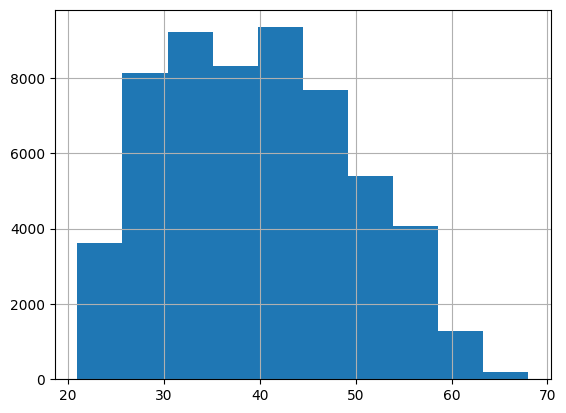

In [ ]:
merged_data["AGE"].hist()

In [ ]:
# Filter out applicants who might not be able to pay back the loan
# Below 21: lenders typically mandate a minimum age of 21 years for loan applicants
# Above 50: do not have many working years left
merged_data = merged_data[(merged_data["AGE"] >= 21) & (merged_data["AGE"] <= 50)]

552775.2381186978

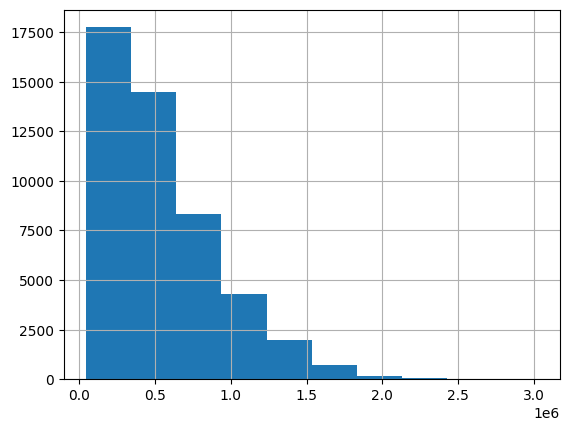

In [ ]:
merged_data["AMT_CREDIT"].hist()
merged_data["AMT_CREDIT"].mean()


In [ ]:
# Filter out credit amount that is too high
merged_data = merged_data[(merged_data["AMT_CREDIT"] <=500000)]
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25287 entries, 0 to 307509
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   25287 non-null  int64  
 1   TARGET                       25287 non-null  int64  
 2   AMT_ANNUITY                  25286 non-null  float64
 3   FLAG_OWN_CAR                 25287 non-null  object 
 4   FLAG_OWN_REALTY              25287 non-null  object 
 5   AMT_INCOME_TOTAL             25287 non-null  float64
 6   AMT_CREDIT                   25287 non-null  float64
 7   AMT_GOODS_PRICE              25241 non-null  float64
 8   NAME_EDUCATION_TYPE          25287 non-null  object 
 9   NAME_FAMILY_STATUS           25287 non-null  object 
 10  NAME_HOUSING_TYPE            25287 non-null  object 
 11  FLAG_CONT_MOBILE             25287 non-null  int64  
 12  CNT_FAM_MEMBERS              25287 non-null  float64
 13  REGION_RATING_CLIENT

## Univariate Analysis

In [ ]:
# Separating columns by type for visualisation
continuous_columns = [
                        "AMT_INCOME_TOTAL",
                        "AMT_GOODS_PRICE",
                        "AMT_CREDIT",
                        "AVG_CNT_CREDIT_PROLONG",
                        "AVG_AMT_CREDIT_SUM_OVERDUE",
                        "AVG_CREDIT_DAY_OVERDUE",
                        "AVG_AMT_CREDIT_MAX_OVERDUE",
                        "AMT_ANNUITY"
                    ]

discrete_columns = [
                        "YEARS_EMPLOYED",
                        "AGE",
                        "CNT_FAM_MEMBERS",
                    ]


categorical_columns = [
                        "TARGET",
                        "FLAG_OWN_CAR",
                        "FLAG_OWN_REALTY",
                        "NAME_EDUCATION_TYPE",
                        "NAME_FAMILY_STATUS",
                        "NAME_HOUSING_TYPE",
                        "FLAG_CONT_MOBILE",
                        "REGION_RATING_CLIENT_W_CITY",
                        "REG_CITY_NOT_LIVE_CITY",
                    ]

### Continuous Numerical Variables

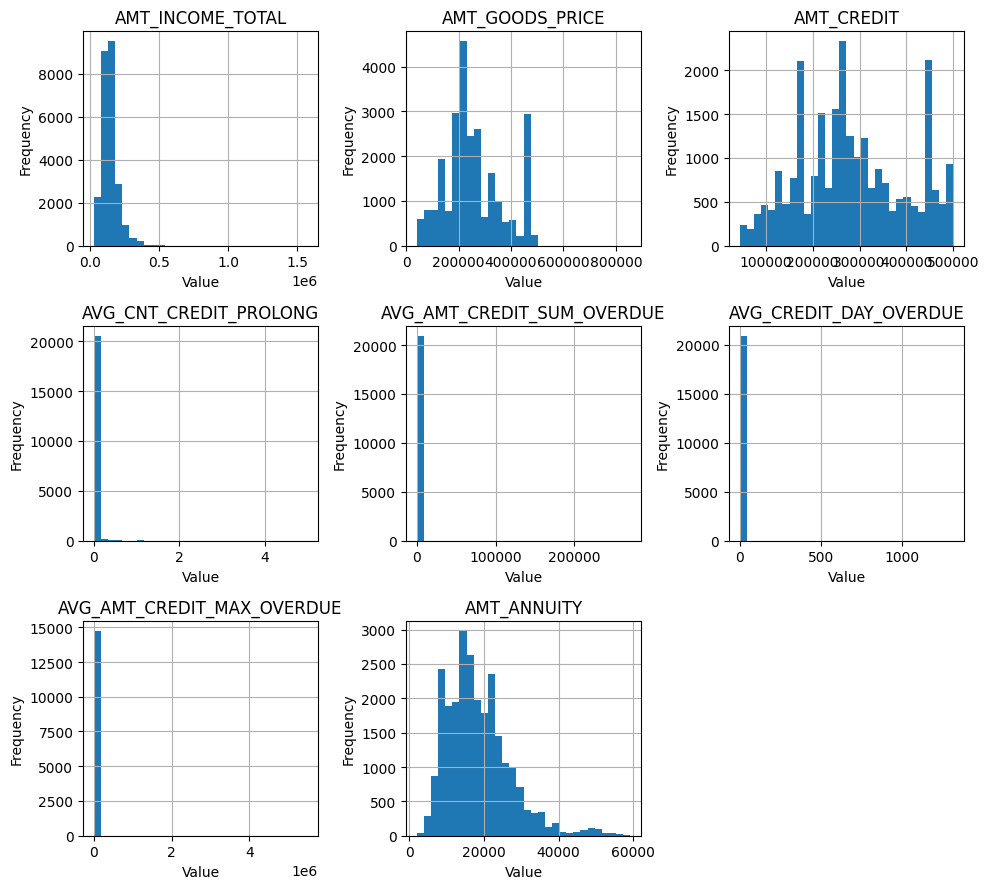

In [ ]:
# Histogram for distribution of continuous numerical variables
num_rows = (len(continuous_columns) + 2) // 3
num_cols = min(len(continuous_columns), 3)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows))
axes = axes.flatten()
for i, column in enumerate(continuous_columns):
    merged_data[column].hist(ax=axes[i], bins=30)
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

### Discrete Numerical Variables

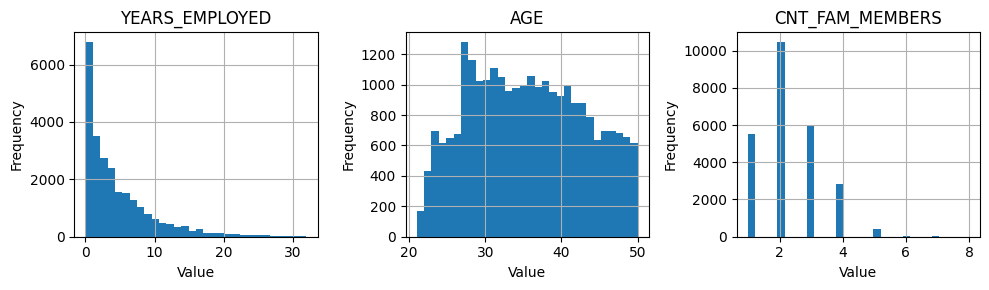

In [ ]:
# Histogram for distribution of discrete numerical variables
num_rows = (len(discrete_columns) + 2) // 3
num_cols = min(len(discrete_columns), 3)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows))
axes = axes.flatten()
for i, column in enumerate(discrete_columns):
    merged_data[column].hist(ax=axes[i], bins=30)
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

### Categorical Variables

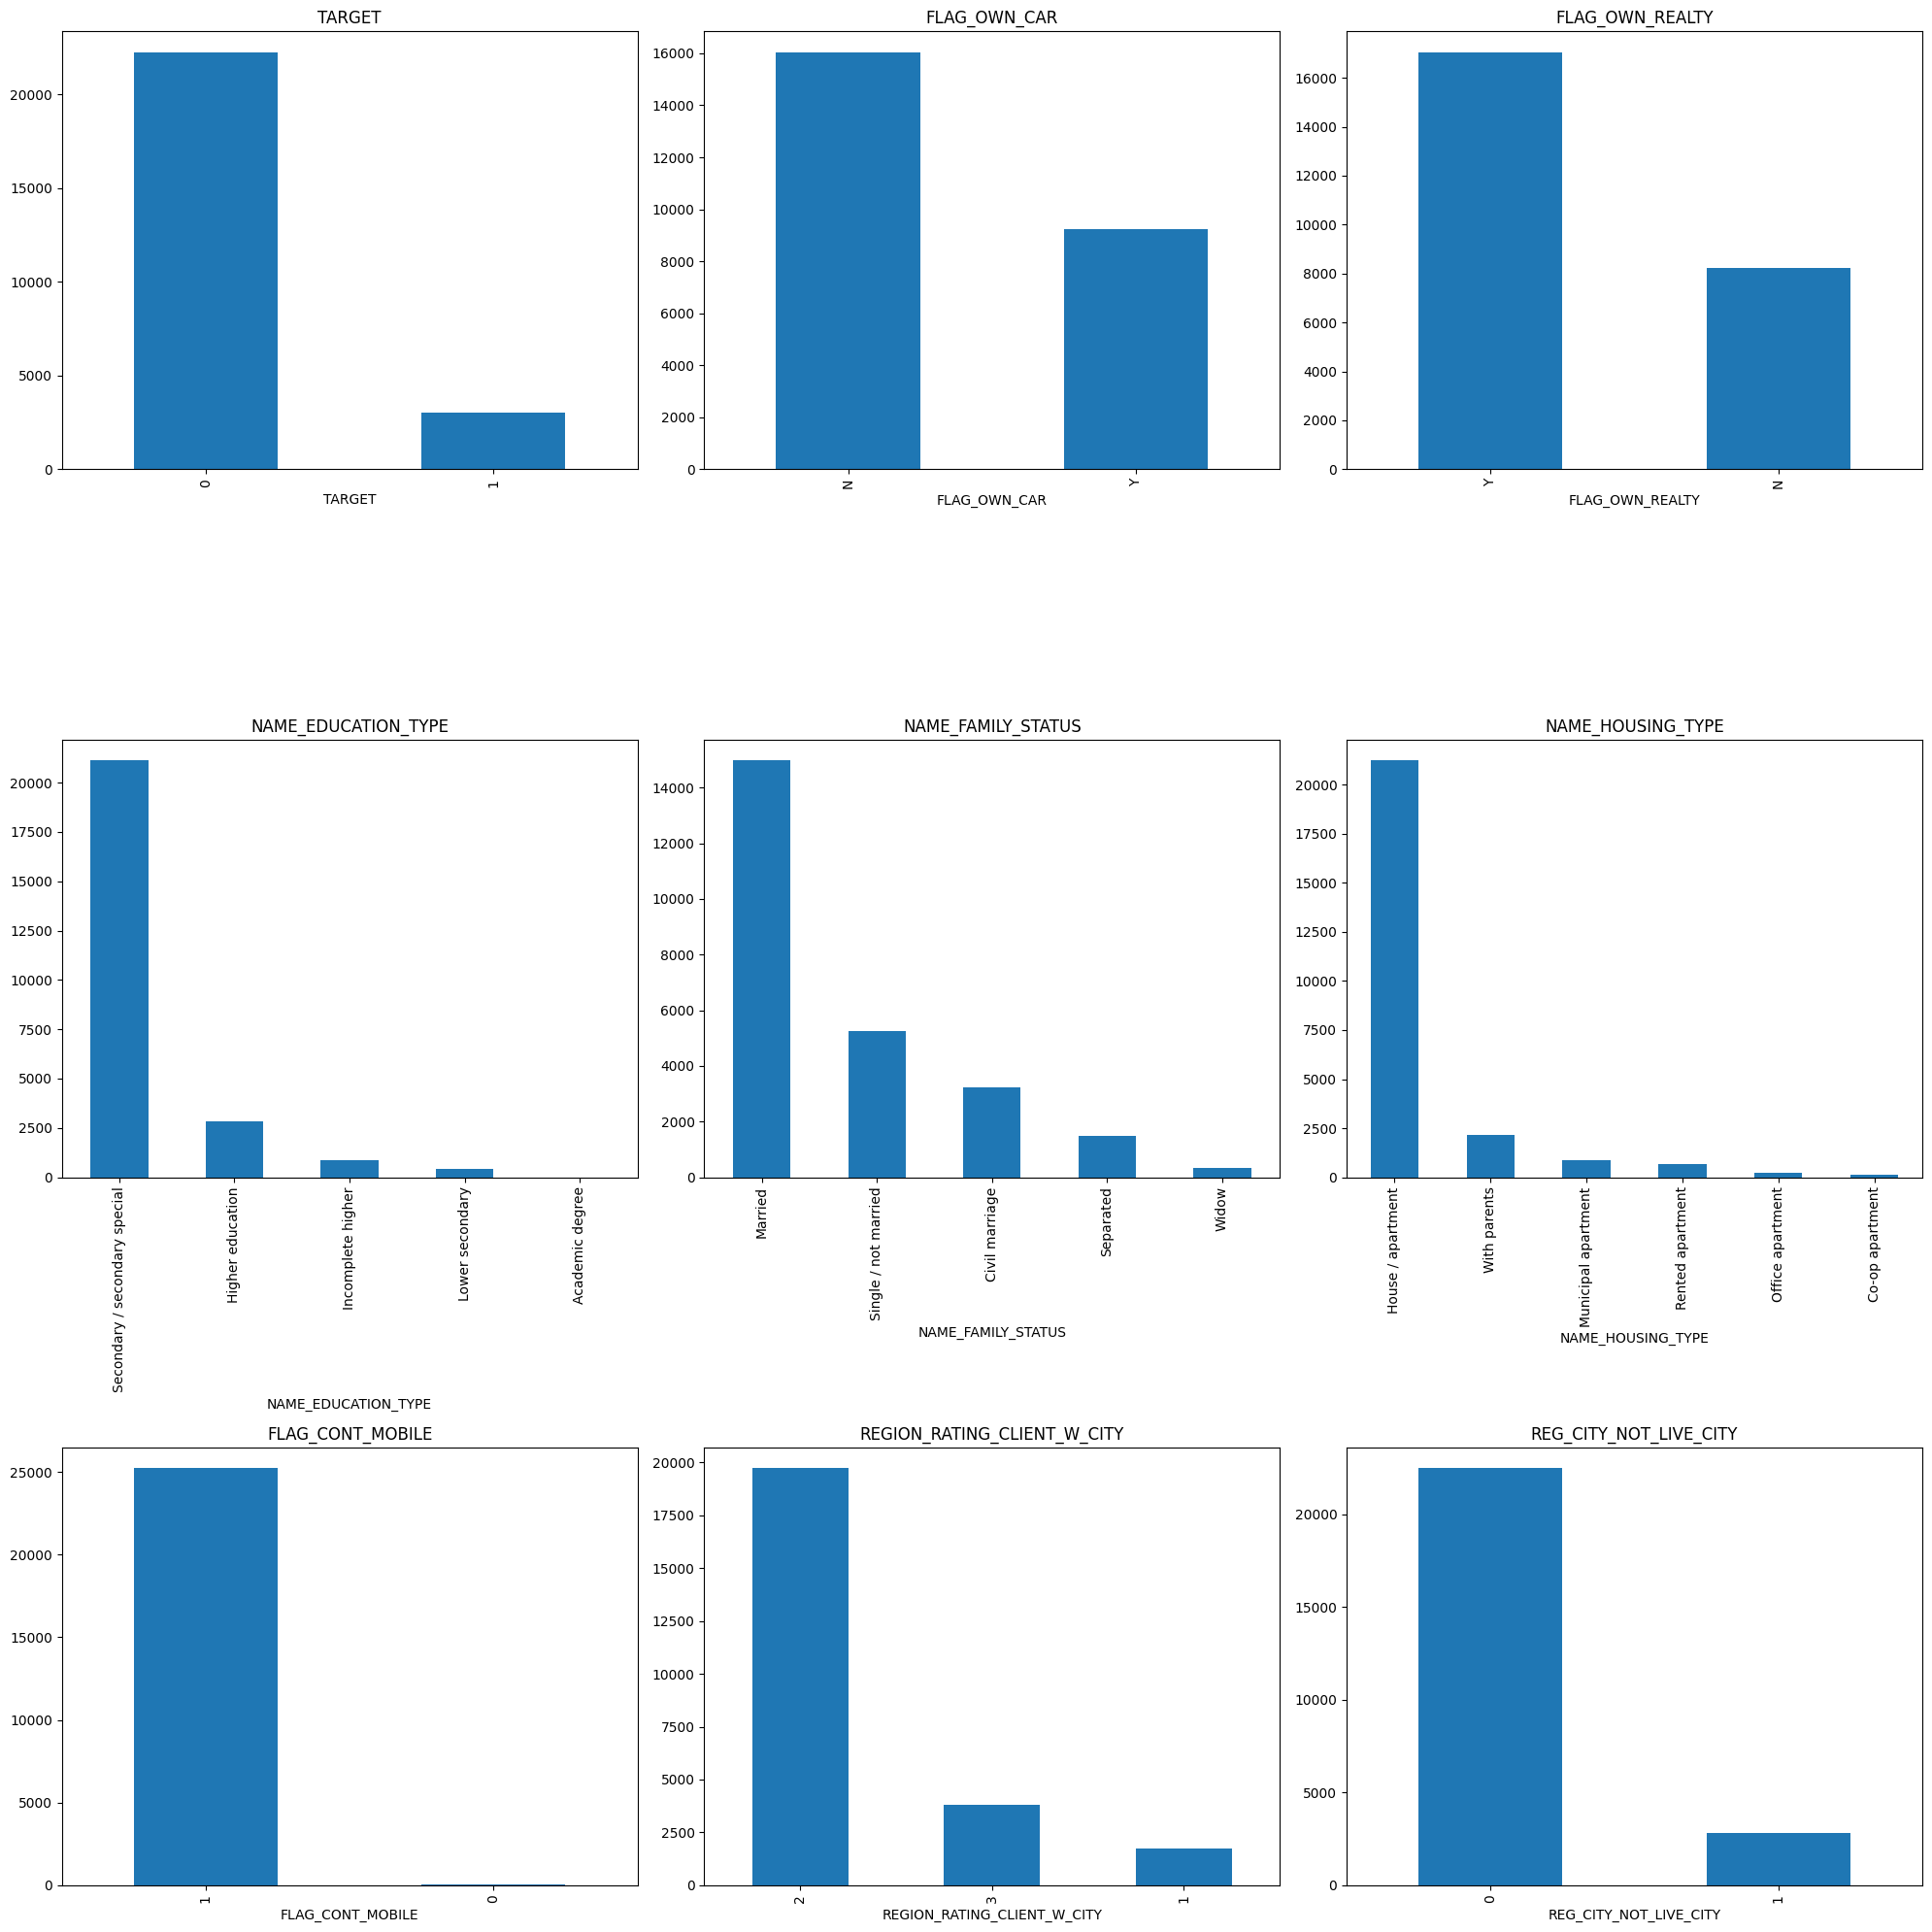

In [ ]:
# Bar chart for distribution of categorical variables
plt.figure(figsize=(20, 20))
for i, column in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns) // 3 + (len(categorical_columns) % 3 > 0), 3, i+1)
    value_counts = merged_data[column].value_counts()
    value_counts.plot(kind='bar')
    plt.title(column)
plt.tight_layout()
plt.show()

## Bivariate Analysis

### Continuous Numerical Variables

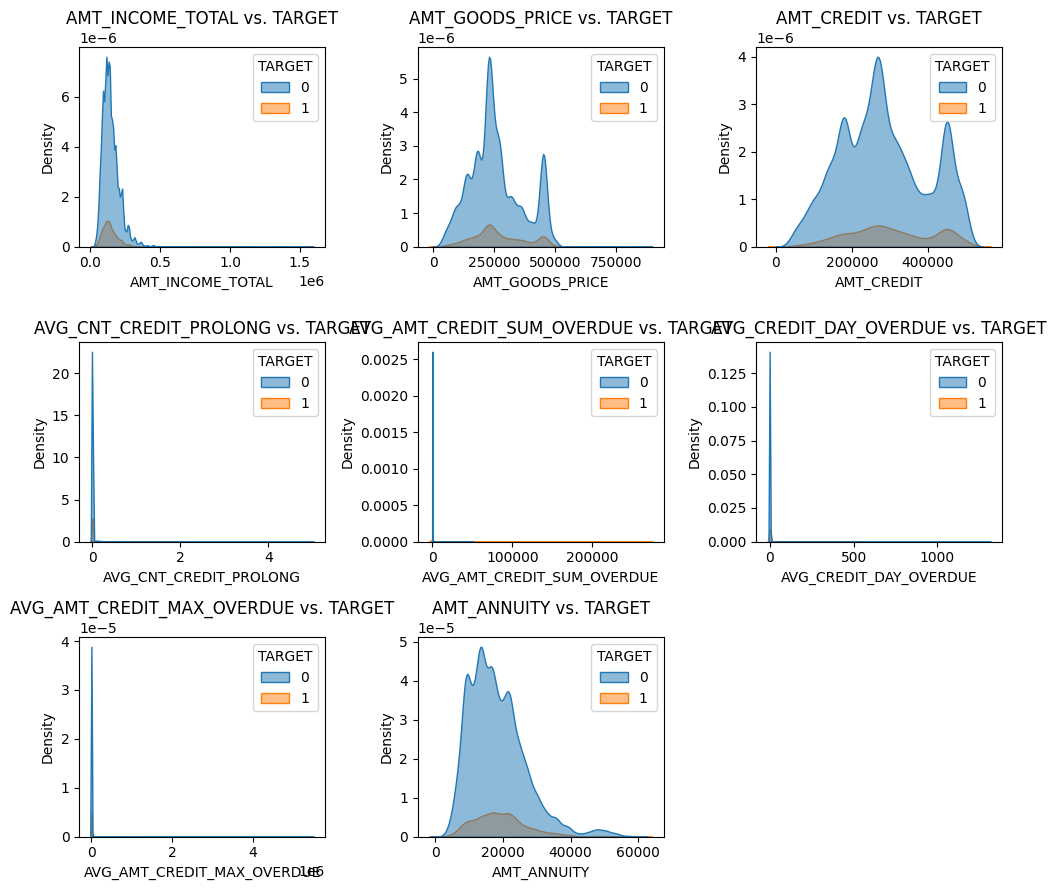

In [ ]:
# KDE plot for continuous variables
num_rows = len(continuous_columns) // 3 + (len(continuous_columns) % 3 > 0)
num_cols = min(len(continuous_columns), 3)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 3*num_rows))
for i, column in enumerate(continuous_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=merged_data, x=column, hue='TARGET', fill=True, alpha=0.5, ax=axes[row, col])
    axes[row, col].set_title(f'{column} vs. TARGET')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Density')
for i in range(len(continuous_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


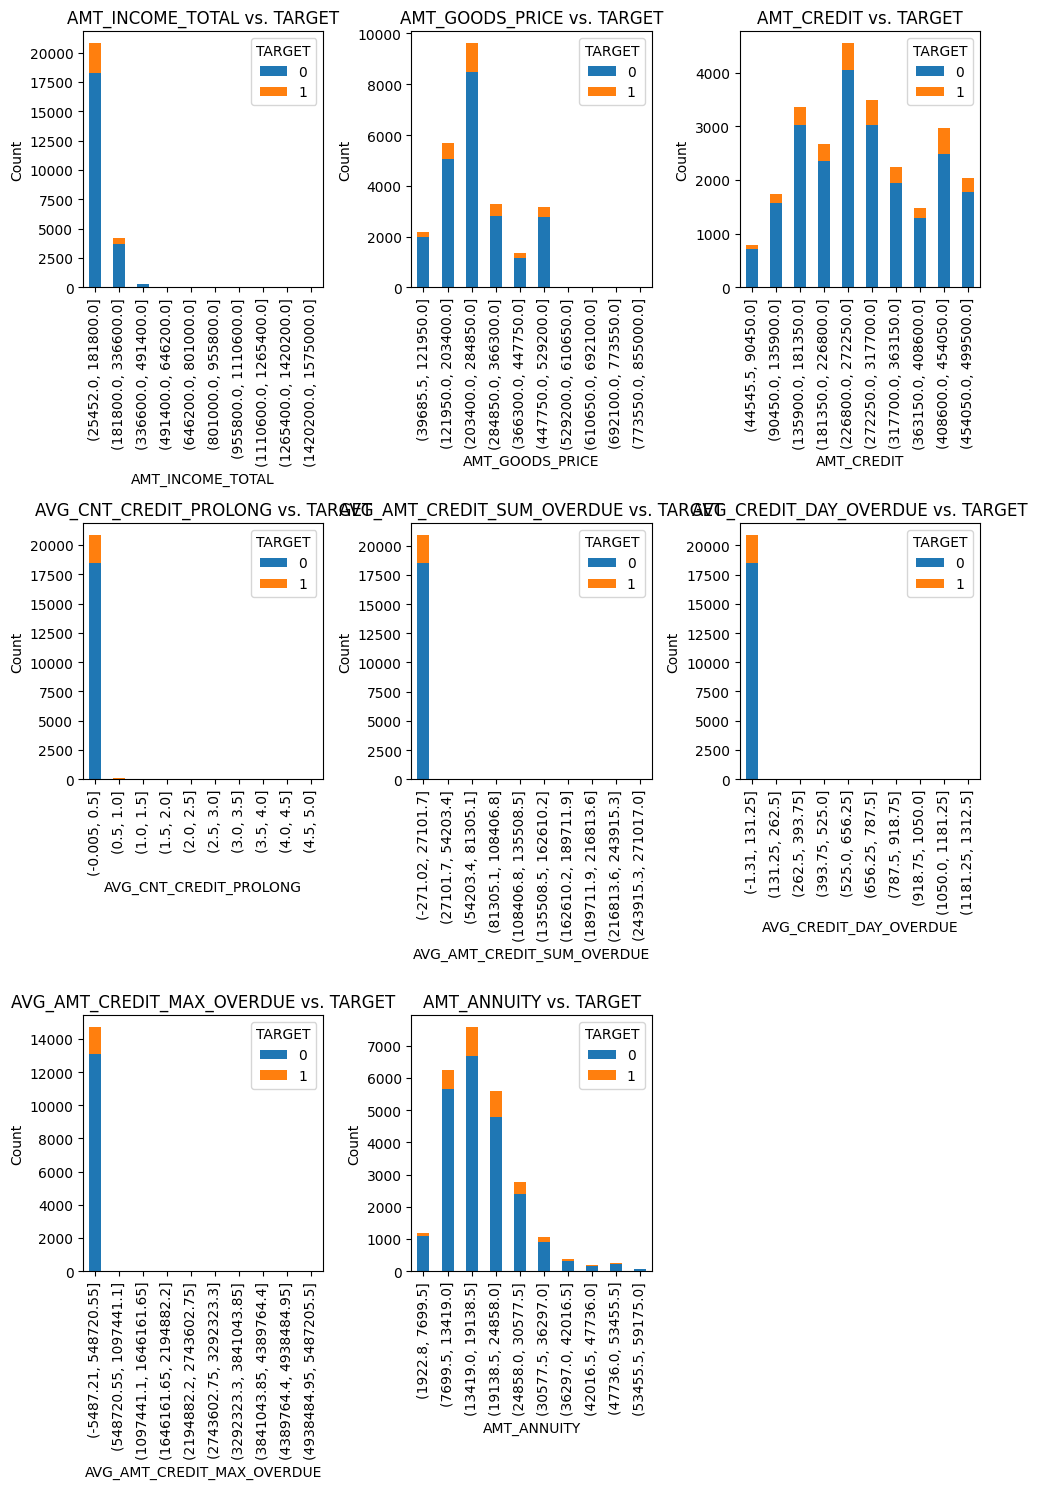

In [ ]:
# Stacked bar chart for continuous variables
num_rows = (len(continuous_columns) + 2) // 3
num_cols = min(len(continuous_columns), 3)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5*num_rows))
axes = axes.flatten()
for i, column in enumerate(continuous_columns):
    bins = pd.cut(merged_data[column], bins=10, precision=2)
    stacked_data = merged_data.groupby([bins, 'TARGET']).size().unstack()
    stacked_data.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{column} vs. TARGET')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
for j in range(len(continuous_columns), num_rows * num_cols):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

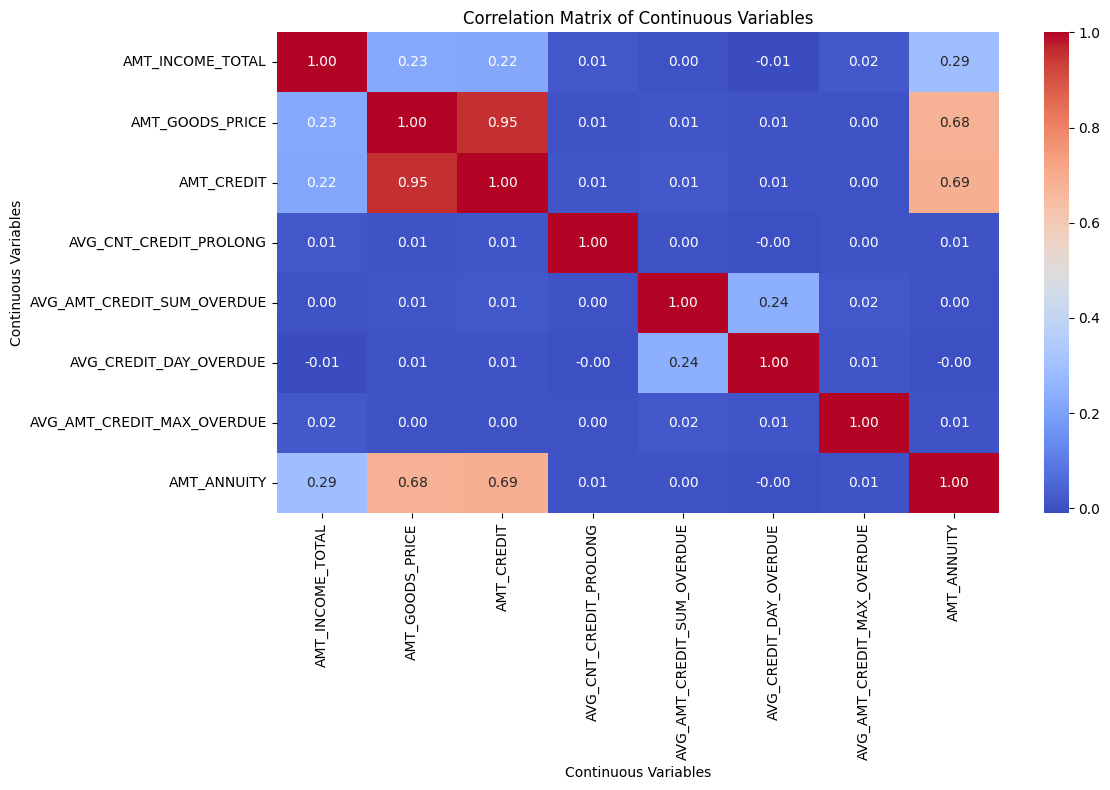

In [ ]:
# Correlation heat map for continuous variables
correlation_matrix = merged_data[continuous_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Continuous Variables')
plt.xlabel('Continuous Variables')
plt.ylabel('Continuous Variables')
plt.tight_layout()
plt.show()

### Discrete Numerical Variables

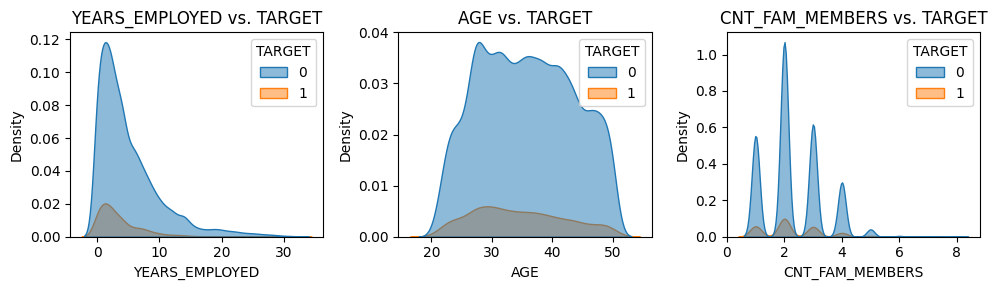

In [ ]:
# KDE plot for discrete variables
num_cols = min(len(discrete_columns), 3)
fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(10, num_cols))

for i, column in enumerate(discrete_columns):
    col = i % num_cols
    sns.kdeplot(data=merged_data, x=column, hue='TARGET', fill=True, alpha=0.5, ax=axes[col])
    axes[col].set_title(f'{column} vs. TARGET')
    axes[col].set_xlabel(column)
    axes[col].set_ylabel('Density')

for i in range(len(discrete_columns), 1 * num_cols):
    col = i % num_cols
    fig.delaxes(axes[col])

plt.tight_layout()
plt.show()

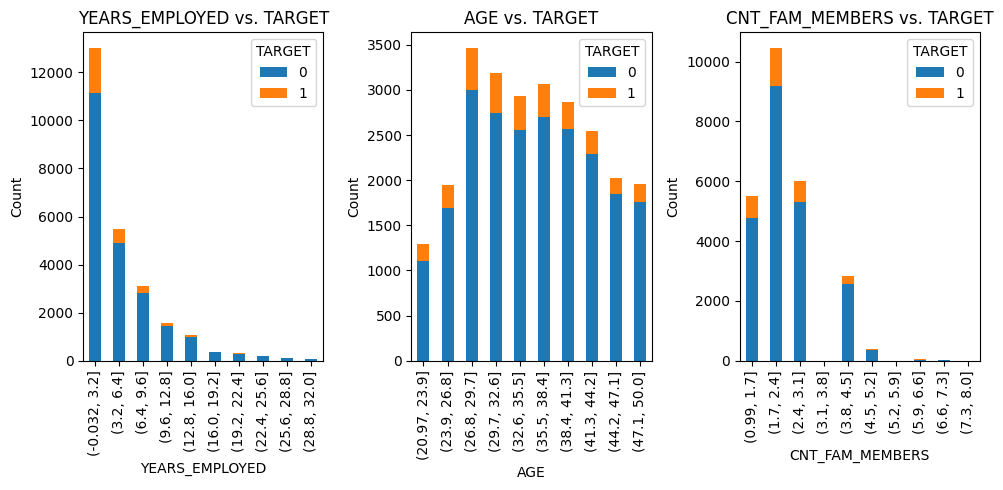

In [ ]:
# Stacked bar chart for discrete variables
num_rows = (len(discrete_columns) + 2) // 3
num_cols = min(len(discrete_columns), 3)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5*num_rows))
axes = axes.flatten()
for i, column in enumerate(discrete_columns):
    bins = pd.cut(merged_data[column], bins=10, precision=2)
    stacked_data = merged_data.groupby([bins, 'TARGET']).size().unstack()
    stacked_data.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{column} vs. TARGET')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
for j in range(len(discrete_columns), num_rows * num_cols):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


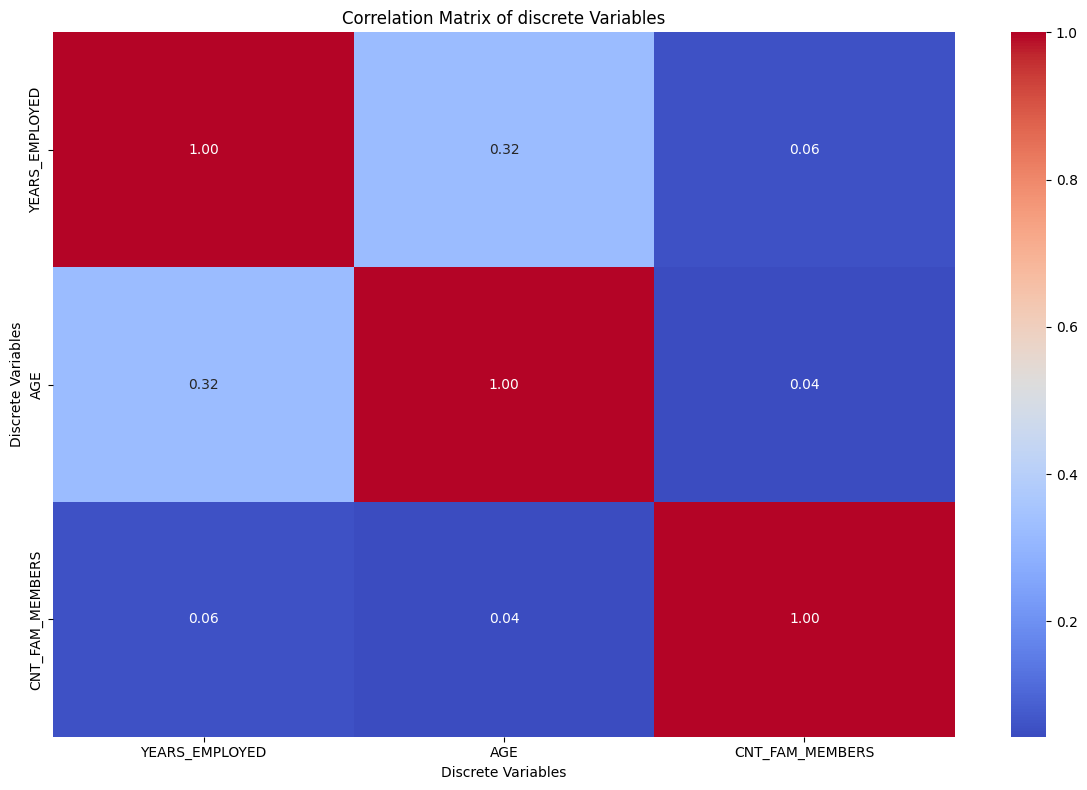

In [ ]:
# Correlation heat map for discrete variables
correlation_matrix = merged_data[discrete_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of discrete Variables')
plt.xlabel('Discrete Variables')
plt.ylabel('Discrete Variables')
plt.tight_layout()
plt.show()

### Categorical Variables

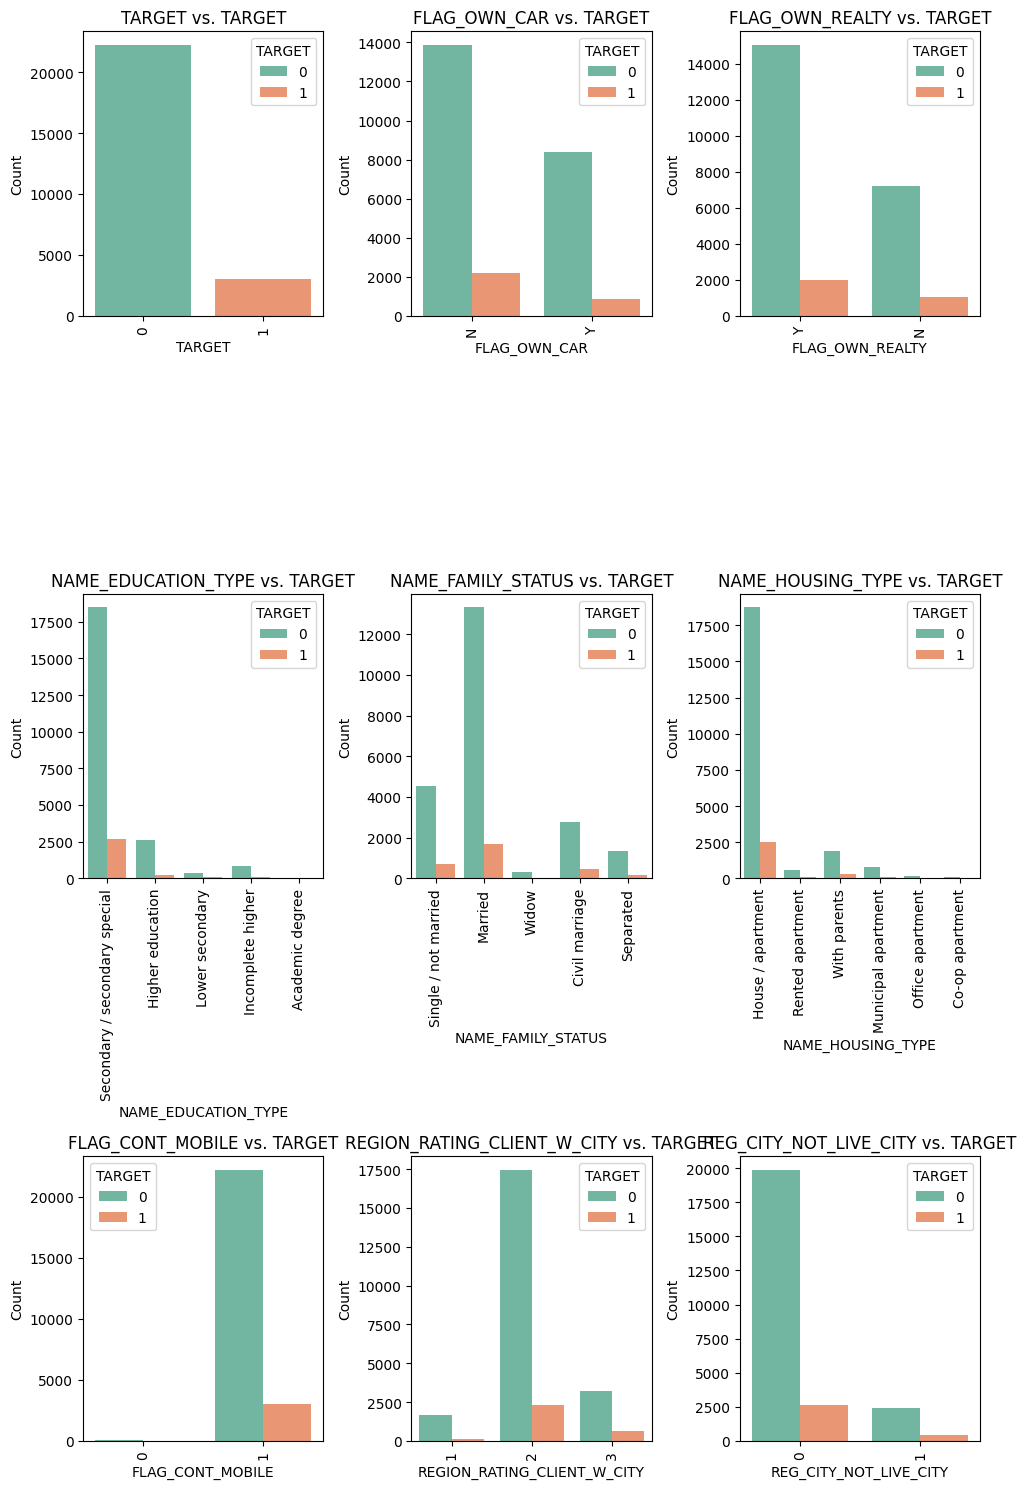

In [ ]:
# Bar Chart for categorical variables
num_rows = len(categorical_columns) // 3 + (len(categorical_columns) % 3 > 0)
num_cols = min(len(categorical_columns), 3)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 5*num_rows))
for i, column in enumerate(categorical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.countplot(x=column, hue='TARGET', data=merged_data, ax=axes[row, col], palette='Set2')
    axes[row, col].set_title(f'{column} vs. TARGET')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Count')
    axes[row, col].tick_params(axis='x', rotation=90)
for i in range(len(categorical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])
plt.tight_layout()
plt.show()


# Data Cleaning and Preparation


## Outliers

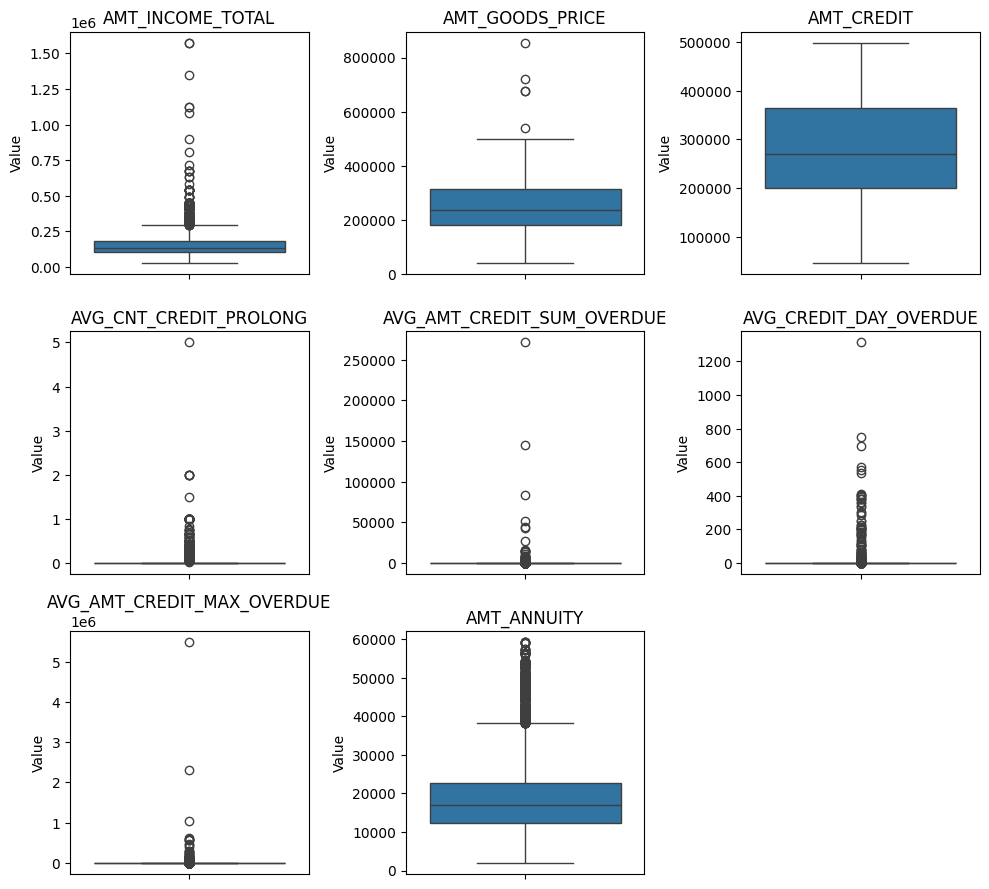

In [ ]:
# Box plot for continuous variables
num_rows = (len(continuous_columns) + 2) // 3
num_cols = min(len(continuous_columns), 3)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows))
axes = axes.flatten()
for i, column in enumerate(continuous_columns):
    sns.boxplot(data=merged_data[column], ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_ylabel('Value')
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

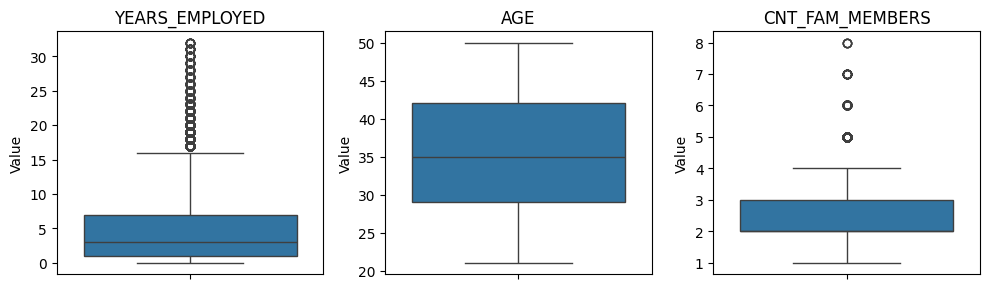

In [ ]:
# Box plot for discrete variables

new_discrete_columns = discrete_columns

if "TARGET" in new_discrete_columns:
  new_discrete_columns.remove("TARGET")

num_rows = (len(discrete_columns) + 2) // 3
num_cols = min(len(discrete_columns), 3)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows))
axes = axes.flatten()
for i, column in enumerate(discrete_columns):
    sns.boxplot(data=merged_data[column], ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_ylabel('Value')
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [ ]:
# using Tukey's fence to find outliers
# choose to cap outliers
# we choose to ignore categorical data, since they can't be reasoned

for column in new_discrete_columns:
  Q1 = merged_data[column].quantile(0.25)
  Q3 = merged_data[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  merged_data[column] = np.where(merged_data[column] < lower_bound, lower_bound, merged_data[column])
  merged_data[column] = np.where(merged_data[column] > upper_bound, upper_bound, merged_data[column])

for column in continuous_columns:
  Q1 = merged_data[column].quantile(0.25)
  Q3 = merged_data[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  merged_data[column] = np.where(merged_data[column] < lower_bound, lower_bound, merged_data[column])
  merged_data[column] = np.where(merged_data[column] > upper_bound, upper_bound, merged_data[column])

## Missing Values

In [ ]:
merged_data.isnull().sum()
# merged_data.info()

# it is observed that close to 17% of observations do not have data recorded in the Bureau
# our group has decided to keep the data and classify them under "missing" for each characteristic

SK_ID_CURR                         0
TARGET                             0
AMT_ANNUITY                        1
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_GOODS_PRICE                   46
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
FLAG_CONT_MOBILE                   0
CNT_FAM_MEMBERS                    0
REGION_RATING_CLIENT_W_CITY        0
REG_CITY_NOT_LIVE_CITY             0
AGE                                0
YEARS_EMPLOYED                     0
AVG_CNT_CREDIT_PROLONG          4379
AVG_AMT_CREDIT_SUM_OVERDUE      4379
AVG_CREDIT_DAY_OVERDUE          4379
AVG_AMT_CREDIT_MAX_OVERDUE     10559
dtype: int64

In [ ]:
# Missing completely at random

# Replace missing values in 'AMT_ANNUITY' column with the mean
mean_annuity_price = merged_data['AMT_ANNUITY'].mean()
merged_data['AMT_ANNUITY'].fillna(mean_annuity_price, inplace=True)

# Replace missing values in 'AMT_GOODS_PRICE' column with the mean
mean_goods_price = merged_data['AMT_GOODS_PRICE'].mean()
merged_data['AMT_GOODS_PRICE'].fillna(mean_goods_price, inplace=True)

merged_data.isnull().sum()

SK_ID_CURR                         0
TARGET                             0
AMT_ANNUITY                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_GOODS_PRICE                    0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
FLAG_CONT_MOBILE                   0
CNT_FAM_MEMBERS                    0
REGION_RATING_CLIENT_W_CITY        0
REG_CITY_NOT_LIVE_CITY             0
AGE                                0
YEARS_EMPLOYED                     0
AVG_CNT_CREDIT_PROLONG          4379
AVG_AMT_CREDIT_SUM_OVERDUE      4379
AVG_CREDIT_DAY_OVERDUE          4379
AVG_AMT_CREDIT_MAX_OVERDUE     10559
dtype: int64

In [ ]:
# drop AVG_AMT_CREDIT_MAX_OVERDUE due to too many null values (around 41%)
percentage_null = merged_data['AVG_AMT_CREDIT_MAX_OVERDUE'].isnull().sum() / merged_data.shape[0]
print(percentage_null)

merged_data.drop('AVG_AMT_CREDIT_MAX_OVERDUE', axis=1, inplace=True)


0.41756633843476887


## Feature Extraction

In [ ]:
print(filtered_bureau_data)
# Filter the different types of loans
active_loan = filtered_bureau_data[filtered_bureau_data["CREDIT_ACTIVE"] == "Active"].groupby("SK_ID_CURR").size().reset_index(name="NO_OF_ACTIVE_LOANS")
sold_loan = filtered_bureau_data[filtered_bureau_data["CREDIT_ACTIVE"] == "Sold"].groupby("SK_ID_CURR").size().reset_index(name="NO_OF_SOLD_LOANS")
bad_debt_loan = filtered_bureau_data[filtered_bureau_data["CREDIT_ACTIVE"] == "Bad debt"].groupby("SK_ID_CURR").size().reset_index(name="NO_OF_BAD_DEBT_LOANS")
closed_loan = filtered_bureau_data[filtered_bureau_data["CREDIT_ACTIVE"] == "Closed"].groupby("SK_ID_CURR").size().reset_index(name="NO_OF_CLOSED_LOANS")

# Merge the different types of loans
loan_dataset = pd.merge(active_loan, sold_loan, on="SK_ID_CURR", how="outer")
loan_dataset = pd.merge(loan_dataset, bad_debt_loan, on="SK_ID_CURR", how="outer")
loan_dataset = pd.merge(loan_dataset, closed_loan, on="SK_ID_CURR", how="outer")

# Fill missing values with 0
loan_dataset.fillna(0, inplace=True)

loan_dataset


         SK_ID_CURR  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM_OVERDUE CREDIT_ACTIVE  \
0            215354                   0                    0.00        Closed   
1            215354                   0                    0.00        Active   
2            215354                   0                    0.00        Active   
3            215354                   0                    0.00        Active   
4            215354                   0                    0.00        Active   
...             ...                 ...                     ...           ...   
1716423      259355                   0                    0.00        Active   
1716424      100044                   0                    0.00        Closed   
1716425      100044                   0                    0.00        Closed   
1716426      246829                   0                    0.00        Closed   
1716427      246829                   0                    0.00        Closed   

         CREDIT_DAY_OVERDUE

,SK_ID_CURR,NO_OF_ACTIVE_LOANS,NO_OF_SOLD_LOANS,NO_OF_BAD_DEBT_LOANS,NO_OF_CLOSED_LOANS
0,100001,3.00,0.00,0.00,4.00
1,100002,2.00,0.00,0.00,6.00
2,100003,1.00,0.00,0.00,3.00
3,100005,2.00,0.00,0.00,1.00
4,100008,1.00,0.00,0.00,2.00
...,...,...,...,...,...
305806,456185,0.00,0.00,0.00,5.00
305807,456191,0.00,0.00,0.00,3.00
305808,456197,0.00,0.00,0.00,7.00
305809,456237,0.00,0.00,0.00,1.00


In [ ]:
# Calculate total loans
loan_dataset["TOTAL_LOANS"] = loan_dataset[["NO_OF_ACTIVE_LOANS", "NO_OF_SOLD_LOANS", "NO_OF_BAD_DEBT_LOANS", "NO_OF_CLOSED_LOANS"]].sum(axis=1)

# Calculate ratios using apply function
loan_dataset["ACTIVE_LOAN_RATIO"] = loan_dataset["NO_OF_ACTIVE_LOANS"] / loan_dataset["TOTAL_LOANS"]
loan_dataset["CLOSED_LOAN_RATIO"] = loan_dataset["NO_OF_CLOSED_LOANS"] / loan_dataset["TOTAL_LOANS"]
loan_dataset["BAD_DEBT_LOAN_RATIO"] = loan_dataset["NO_OF_BAD_DEBT_LOANS"] / loan_dataset["TOTAL_LOANS"]
loan_dataset["SOLD_LOAN_RATIO"] = loan_dataset["NO_OF_SOLD_LOANS"] / loan_dataset["TOTAL_LOANS"]

# Drop unnecessary columns
loan_dataset.drop(["NO_OF_ACTIVE_LOANS", "NO_OF_CLOSED_LOANS", "NO_OF_BAD_DEBT_LOANS", "NO_OF_SOLD_LOANS"], axis=1, inplace=True)

loan_dataset


,SK_ID_CURR,TOTAL_LOANS,ACTIVE_LOAN_RATIO,CLOSED_LOAN_RATIO,BAD_DEBT_LOAN_RATIO,SOLD_LOAN_RATIO
0,100001,7.00,0.43,0.57,0.00,0.00
1,100002,8.00,0.25,0.75,0.00,0.00
2,100003,4.00,0.25,0.75,0.00,0.00
3,100005,3.00,0.67,0.33,0.00,0.00
4,100008,3.00,0.33,0.67,0.00,0.00
...,...,...,...,...,...,...
305806,456185,5.00,0.00,1.00,0.00,0.00
305807,456191,3.00,0.00,1.00,0.00,0.00
305808,456197,7.00,0.00,1.00,0.00,0.00
305809,456237,1.00,0.00,1.00,0.00,0.00


array([[<Axes: title={'center': 'SK_ID_CURR'}>,
        <Axes: title={'center': 'TOTAL_LOANS'}>],
       [<Axes: title={'center': 'ACTIVE_LOAN_RATIO'}>,
        <Axes: title={'center': 'CLOSED_LOAN_RATIO'}>],
       [<Axes: title={'center': 'BAD_DEBT_LOAN_RATIO'}>,
        <Axes: title={'center': 'SOLD_LOAN_RATIO'}>]], dtype=object)

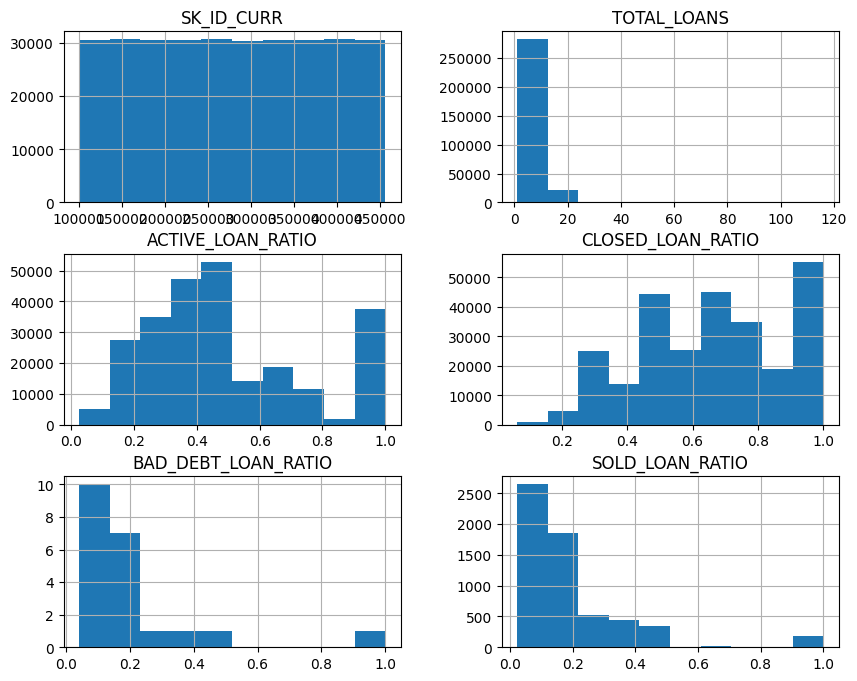

In [ ]:
# removed 0 from data for visualisation
loan_dataset[loan_dataset != 0].hist(figsize=(10, 8))

In [ ]:
# # removing total loans as it is already taken into account in all the other columns
loan_dataset = loan_dataset.drop('TOTAL_LOANS', axis=1)
loan_dataset

,SK_ID_CURR,ACTIVE_LOAN_RATIO,CLOSED_LOAN_RATIO,BAD_DEBT_LOAN_RATIO,SOLD_LOAN_RATIO
0,100001,0.43,0.57,0.00,0.00
1,100002,0.25,0.75,0.00,0.00
2,100003,0.25,0.75,0.00,0.00
3,100005,0.67,0.33,0.00,0.00
4,100008,0.33,0.67,0.00,0.00
...,...,...,...,...,...
305806,456185,0.00,1.00,0.00,0.00
305807,456191,0.00,1.00,0.00,0.00
305808,456197,0.00,1.00,0.00,0.00
305809,456237,0.00,1.00,0.00,0.00


In [ ]:
merged_data = pd.merge(merged_data, loan_dataset)

merged_data

,SK_ID_CURR,TARGET,AMT_ANNUITY,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,REG_CITY_NOT_LIVE_CITY,AGE,YEARS_EMPLOYED,AVG_CNT_CREDIT_PROLONG,AVG_AMT_CREDIT_SUM_OVERDUE,AVG_CREDIT_DAY_OVERDUE,ACTIVE_LOAN_RATIO,CLOSED_LOAN_RATIO,BAD_DEBT_LOAN_RATIO,SOLD_LOAN_RATIO
0,100002,1,24700.50,N,Y,202500.00,406597.50,351000.00,Secondary / secondary special,Single / not married,...,0,25.00,1.00,0.00,0.00,0.00,0.25,0.75,0.00,0.00
1,100008,0,27517.50,N,Y,99000.00,490495.50,454500.00,Secondary / secondary special,Married,...,0,46.00,4.00,0.00,0.00,0.00,0.33,0.67,0.00,0.00
2,100016,0,5881.50,N,Y,67500.00,80865.00,67500.00,Secondary / secondary special,Married,...,0,36.00,7.00,0.00,0.00,0.00,0.57,0.43,0.00,0.00
3,100019,0,20160.00,Y,Y,157500.00,299772.00,247500.00,Secondary / secondary special,Single / not married,...,1,23.00,3.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,100022,0,7875.00,N,Y,112500.00,157500.00,157500.00,Secondary / secondary special,Widow,...,0,48.00,16.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20903,456108,1,33444.00,N,Y,135000.00,457834.50,378000.00,Secondary / secondary special,Married,...,0,34.00,5.00,0.00,0.00,0.00,0.50,0.50,0.00,0.00
20904,456186,1,32746.50,N,N,207000.00,450000.00,450000.00,Secondary / secondary special,Married,...,0,27.00,8.00,0.00,0.00,0.00,0.36,0.64,0.00,0.00
20905,456234,0,9148.50,N,Y,81000.00,135000.00,135000.00,Higher education,Single / not married,...,0,27.00,5.00,0.00,0.00,0.00,0.30,0.70,0.00,0.00
20906,456246,0,10620.00,N,Y,94500.00,225000.00,225000.00,Secondary / secondary special,Married,...,0,44.00,16.00,0.00,0.00,0.00,0.33,0.67,0.00,0.00


In [ ]:
# adding debt to income ratio
merged_data["DEBT_INCOME_RATIO"] = merged_data["AMT_CREDIT"] / merged_data["AMT_INCOME_TOTAL"]
merged_data["DEBT_INCOME_RATIO"] = merged_data["DEBT_INCOME_RATIO"].astype(float).round(2)

# proceed to drop AMT_CREDIT and AMT_INCOME_TOTAL
merged_data.drop(columns=["AMT_CREDIT", "AMT_INCOME_TOTAL"], axis=1, inplace=True)

merged_data

,SK_ID_CURR,TARGET,AMT_ANNUITY,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_CONT_MOBILE,...,AGE,YEARS_EMPLOYED,AVG_CNT_CREDIT_PROLONG,AVG_AMT_CREDIT_SUM_OVERDUE,AVG_CREDIT_DAY_OVERDUE,ACTIVE_LOAN_RATIO,CLOSED_LOAN_RATIO,BAD_DEBT_LOAN_RATIO,SOLD_LOAN_RATIO,DEBT_INCOME_RATIO
0,100002,1,24700.50,N,Y,351000.00,Secondary / secondary special,Single / not married,House / apartment,1,...,25.00,1.00,0.00,0.00,0.00,0.25,0.75,0.00,0.00,2.01
1,100008,0,27517.50,N,Y,454500.00,Secondary / secondary special,Married,House / apartment,1,...,46.00,4.00,0.00,0.00,0.00,0.33,0.67,0.00,0.00,4.95
2,100016,0,5881.50,N,Y,67500.00,Secondary / secondary special,Married,House / apartment,1,...,36.00,7.00,0.00,0.00,0.00,0.57,0.43,0.00,0.00,1.20
3,100019,0,20160.00,Y,Y,247500.00,Secondary / secondary special,Single / not married,Rented apartment,1,...,23.00,3.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.90
4,100022,0,7875.00,N,Y,157500.00,Secondary / secondary special,Widow,House / apartment,1,...,48.00,16.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20903,456108,1,33444.00,N,Y,378000.00,Secondary / secondary special,Married,House / apartment,1,...,34.00,5.00,0.00,0.00,0.00,0.50,0.50,0.00,0.00,3.39
20904,456186,1,32746.50,N,N,450000.00,Secondary / secondary special,Married,House / apartment,1,...,27.00,8.00,0.00,0.00,0.00,0.36,0.64,0.00,0.00,2.17
20905,456234,0,9148.50,N,Y,135000.00,Higher education,Single / not married,House / apartment,1,...,27.00,5.00,0.00,0.00,0.00,0.30,0.70,0.00,0.00,1.67
20906,456246,0,10620.00,N,Y,225000.00,Secondary / secondary special,Married,House / apartment,1,...,44.00,16.00,0.00,0.00,0.00,0.33,0.67,0.00,0.00,2.38


## Feature Selection

In [ ]:
# drop redundant columns
merged_data=merged_data.drop(['SK_ID_CURR'], axis=1)

In [ ]:
numeric_columns = [
                    "AMT_GOODS_PRICE",
                    "AVG_CNT_CREDIT_PROLONG",
                    "AVG_AMT_CREDIT_SUM_OVERDUE",
                    "AVG_CREDIT_DAY_OVERDUE",
                    "YEARS_EMPLOYED",
                    "CNT_FAM_MEMBERS",
                    "ACTIVE_LOAN_RATIO",
                    "CLOSED_LOAN_RATIO",
                    "BAD_DEBT_LOAN_RATIO",
                    "SOLD_LOAN_RATIO",
                    "DEBT_INCOME_RATIO",
                    "AMT_ANNUITY"
                ]

### Correlation

In [ ]:
# Calculate correlation matrix for numeric variables only
corr_matrix = merged_data[numeric_columns].corr()
corr_matrix_top = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Create a DataFrame from the stack
corr_table = corr_matrix_top.stack().reset_index()
corr_table.columns = ['Var1', 'Var2', 'Correlation']

# Filter out pairs with high correlation
high_corr_pairs = corr_table[corr_table['Correlation'] > 0.7]
print(high_corr_pairs)

# Deciding which variable to keep might require domain knowledge or further analysis
# For demonstration, let's assume we keep the first variable of each pair
# This could be refined based on feature importance or other criteria

unique_high_corr_pairs = high_corr_pairs['Var2'].unique()
print("High Correlated Pairs:", unique_high_corr_pairs)


Empty DataFrame
Columns: [Var1, Var2, Correlation]
Index: []
High Correlated Pairs: []


### Multicollinearity

In [ ]:
# Function to calculate VIF after imputing missing values
def calculate_vif(data):
    # Impute missing values with mean
    data_imputed = data.fillna(data.mean())

    # Calculate VIF for each predictor variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_imputed.columns
    vif_data["VIF"] = [vif(data_imputed.values, i) for i in range(len(data_imputed.columns))]

    return vif_data

# Calculate VIF for predictors
vif_result = calculate_vif(merged_data[numeric_columns])

# Display VIF values
print(vif_result)


                      Variable  VIF
0              AMT_GOODS_PRICE 2.54
1       AVG_CNT_CREDIT_PROLONG  NaN
2   AVG_AMT_CREDIT_SUM_OVERDUE  NaN
3       AVG_CREDIT_DAY_OVERDUE  NaN
4               YEARS_EMPLOYED 1.02
5              CNT_FAM_MEMBERS 1.01
6            ACTIVE_LOAN_RATIO 5.09
7            CLOSED_LOAN_RATIO 7.43
8          BAD_DEBT_LOAN_RATIO 1.00
9              SOLD_LOAN_RATIO 1.03
10           DEBT_INCOME_RATIO 1.48
11                 AMT_ANNUITY 1.93


 VIF of AVG_CNT_CREDIT_PROLONG, AVG_AMT_CREDIT_SUM_OVERDUE and AVG_CREDIT_DAY_OVERDUE are NaN due to imputation of missing values with mean.

 VIF of the other columns are relatively low.

 VIF of CLOSED_LOAN_RATIO is > 5, which is considered to have high collinearity. Hence it will be removed.

In [ ]:
merged_data.drop("CLOSED_LOAN_RATIO", axis=1, inplace=True)

# Grouping and Screening

## Fine Classing

In [ ]:
bins = sc.woebin(merged_data, y='TARGET')
for variables , bindetails in bins.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

[INFO] creating woe binning ...
ACTIVE_LOAN_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ACTIVE_LOAN_RATIO,"[-inf,0.34)",9802,0.47,8930,872,0.09,-0.27,0.03,0.07,0.34,False
1,ACTIVE_LOAN_RATIO,"[0.34,0.52)",4780,0.23,4242,538,0.11,-0.01,0.00,0.07,0.52,False
2,ACTIVE_LOAN_RATIO,"[0.52,0.76)",2796,0.13,2404,392,0.14,0.24,0.01,0.07,0.76,False
3,ACTIVE_LOAN_RATIO,"[0.76,inf)",3530,0.17,2961,569,0.16,0.41,0.03,0.07,inf,False


----------------------------------------------------------------------------------------------------
FLAG_OWN_REALTY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_OWN_REALTY,Y,14075,0.67,12522,1553,0.11,-0.03,0.00,0.00,Y,False
1,FLAG_OWN_REALTY,N,6833,0.33,6015,818,0.12,0.06,0.00,0.00,N,False


----------------------------------------------------------------------------------------------------
FLAG_CONT_MOBILE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_CONT_MOBILE,"[-inf,inf)",20908,1.00,18537,2371,0.11,0.00,0.00,0.00,inf,False


----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY,"[-inf,15000.0)",8341,0.40,7608,733,0.09,-0.28,0.03,0.05,15000.0,False
1,AMT_ANNUITY,"[15000.0,17000.0)",2169,0.10,1915,254,0.12,0.04,0.00,0.05,17000.0,False
2,AMT_ANNUITY,"[17000.0,inf)",10398,0.50,9014,1384,0.13,0.18,0.02,0.05,inf,False


----------------------------------------------------------------------------------------------------
FLAG_OWN_CAR  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_OWN_CAR,Y,7888,0.38,7196,692,0.09,-0.29,0.03,0.04,Y,False
1,FLAG_OWN_CAR,N,13020,0.62,11341,1679,0.13,0.15,0.01,0.04,N,False


----------------------------------------------------------------------------------------------------
YEARS_EMPLOYED  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_EMPLOYED,"[-inf,3.0)",8150,0.39,7001,1149,0.14,0.25,0.03,0.08,3.0,False
1,YEARS_EMPLOYED,"[3.0,5.0)",4217,0.20,3712,505,0.12,0.06,0.00,0.08,5.0,False
2,YEARS_EMPLOYED,"[5.0,11.0)",5820,0.28,5269,551,0.09,-0.20,0.01,0.08,11.0,False
3,YEARS_EMPLOYED,"[11.0,inf)",2721,0.13,2555,166,0.06,-0.68,0.05,0.08,inf,False


----------------------------------------------------------------------------------------------------
SOLD_LOAN_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,SOLD_LOAN_RATIO,"[-inf,inf)",20908,1.00,18537,2371,0.11,0.00,0.00,0.00,inf,False


----------------------------------------------------------------------------------------------------
CNT_FAM_MEMBERS  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CNT_FAM_MEMBERS,"[-inf,3.0)",12940,0.62,11423,1517,0.12,0.04,0.00,0.00,3.0,False
1,CNT_FAM_MEMBERS,"[3.0,4.0)",5129,0.25,4552,577,0.11,-0.01,0.00,0.00,4.0,False
2,CNT_FAM_MEMBERS,"[4.0,inf)",2839,0.14,2562,277,0.10,-0.17,0.00,0.00,inf,False


----------------------------------------------------------------------------------------------------
REG_CITY_NOT_LIVE_CITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REG_CITY_NOT_LIVE_CITY,"[-inf,1.0)",18674,0.89,16615,2059,0.11,-0.03,0.00,0.01,1.0,False
1,REG_CITY_NOT_LIVE_CITY,"[1.0,inf)",2234,0.11,1922,312,0.14,0.24,0.01,0.01,inf,False


----------------------------------------------------------------------------------------------------
DEBT_INCOME_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBT_INCOME_RATIO,"[-inf,1.2000000000000002)",3662,0.18,3348,314,0.09,-0.31,0.01,0.04,1.2000000000000002,False
1,DEBT_INCOME_RATIO,"[1.2000000000000002,2.0)",6191,0.30,5539,652,0.11,-0.08,0.00,0.04,2.0,False
2,DEBT_INCOME_RATIO,"[2.0,2.1)",1292,0.06,1179,113,0.09,-0.29,0.00,0.04,2.1,False
3,DEBT_INCOME_RATIO,"[2.1,inf)",9763,0.47,8471,1292,0.13,0.18,0.02,0.04,inf,False


----------------------------------------------------------------------------------------------------
NAME_EDUCATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_EDUCATION_TYPE,"Academic degree%,%Higher education%,%Incomplet...",3196,0.15,2951,245,0.08,-0.43,0.02,0.03,"Academic degree%,%Higher education%,%Incomplet...",False
1,NAME_EDUCATION_TYPE,"Secondary / secondary special%,%Lower secondary",17712,0.85,15586,2126,0.12,0.06,0.00,0.03,"Secondary / secondary special%,%Lower secondary",False


----------------------------------------------------------------------------------------------------
AMT_GOODS_PRICE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_GOODS_PRICE,"[-inf,100000.0)",1227,0.06,1131,96,0.08,-0.41,0.01,0.04,100000.0,False
1,AMT_GOODS_PRICE,"[100000.0,140000.0)",1768,0.08,1602,166,0.09,-0.21,0.00,0.04,140000.0,False
2,AMT_GOODS_PRICE,"[140000.0,210000.0)",3406,0.16,3058,348,0.10,-0.12,0.00,0.04,210000.0,False
3,AMT_GOODS_PRICE,"[210000.0,230000.0)",3730,0.18,3245,485,0.13,0.16,0.00,0.04,230000.0,False
4,AMT_GOODS_PRICE,"[230000.0,280000.0)",4076,0.19,3695,381,0.09,-0.22,0.01,0.04,280000.0,False
5,AMT_GOODS_PRICE,"[280000.0,inf)",6701,0.32,5806,895,0.13,0.19,0.01,0.04,inf,False


----------------------------------------------------------------------------------------------------
NAME_FAMILY_STATUS  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_FAMILY_STATUS,"Widow%,%Married",13042,0.62,11637,1405,0.11,-0.06,0.00,0.01,"Widow%,%Married",False
1,NAME_FAMILY_STATUS,Separated,1272,0.06,1129,143,0.11,-0.01,0.00,0.01,Separated,False
2,NAME_FAMILY_STATUS,Single / not married,4062,0.19,3572,490,0.12,0.07,0.00,0.01,Single / not married,False
3,NAME_FAMILY_STATUS,Civil marriage,2532,0.12,2199,333,0.13,0.17,0.00,0.01,Civil marriage,False


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT_W_CITY,"[-inf,2.0)",1447,0.07,1363,84,0.06,-0.73,0.03,0.05,2.0,False
1,REGION_RATING_CLIENT_W_CITY,"[2.0,3.0)",16366,0.78,14544,1822,0.11,-0.02,0.00,0.05,3.0,False
2,REGION_RATING_CLIENT_W_CITY,"[3.0,inf)",3095,0.15,2630,465,0.15,0.32,0.02,0.05,inf,False


----------------------------------------------------------------------------------------------------
AGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AGE,"[-inf,30.0)",5269,0.25,4591,678,0.13,0.14,0.01,0.03,30.0,False
1,AGE,"[30.0,32.0)",1777,0.08,1513,264,0.15,0.31,0.01,0.03,32.0,False
2,AGE,"[32.0,39.0)",5946,0.28,5257,689,0.12,0.02,0.00,0.03,39.0,False
3,AGE,"[39.0,inf)",7916,0.38,7176,740,0.09,-0.22,0.02,0.03,inf,False


----------------------------------------------------------------------------------------------------
NAME_HOUSING_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_HOUSING_TYPE,"Office apartment%,%Co-op apartment%,%Municipal...",18648,0.89,16576,2072,0.11,-0.02,0.00,0.00,"Office apartment%,%Co-op apartment%,%Municipal...",False
1,NAME_HOUSING_TYPE,"With parents%,%Rented apartment",2260,0.11,1961,299,0.13,0.18,0.00,0.00,"With parents%,%Rented apartment",False


----------------------------------------------------------------------------------------------------
BAD_DEBT_LOAN_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,BAD_DEBT_LOAN_RATIO,"[-inf,inf)",20908,1.00,18537,2371,0.11,0.00,0.00,0.00,inf,False


----------------------------------------------------------------------------------------------------


{'ACTIVE_LOAN_RATIO': <Figure size 640x480 with 2 Axes>,
 'FLAG_OWN_REALTY': <Figure size 640x480 with 2 Axes>,
 'FLAG_CONT_MOBILE': <Figure size 640x480 with 2 Axes>,
 'AMT_ANNUITY': <Figure size 640x480 with 2 Axes>,
 'FLAG_OWN_CAR': <Figure size 640x480 with 2 Axes>,
 'YEARS_EMPLOYED': <Figure size 640x480 with 2 Axes>,
 'SOLD_LOAN_RATIO': <Figure size 640x480 with 2 Axes>,
 'CNT_FAM_MEMBERS': <Figure size 640x480 with 2 Axes>,
 'REG_CITY_NOT_LIVE_CITY': <Figure size 640x480 with 2 Axes>,
 'DEBT_INCOME_RATIO': <Figure size 640x480 with 2 Axes>,
 'NAME_EDUCATION_TYPE': <Figure size 640x480 with 2 Axes>,
 'AMT_GOODS_PRICE': <Figure size 640x480 with 2 Axes>,
 'NAME_FAMILY_STATUS': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'AGE': <Figure size 640x480 with 2 Axes>,
 'NAME_HOUSING_TYPE': <Figure size 640x480 with 2 Axes>,
 'BAD_DEBT_LOAN_RATIO': <Figure size 640x480 with 2 Axes>}

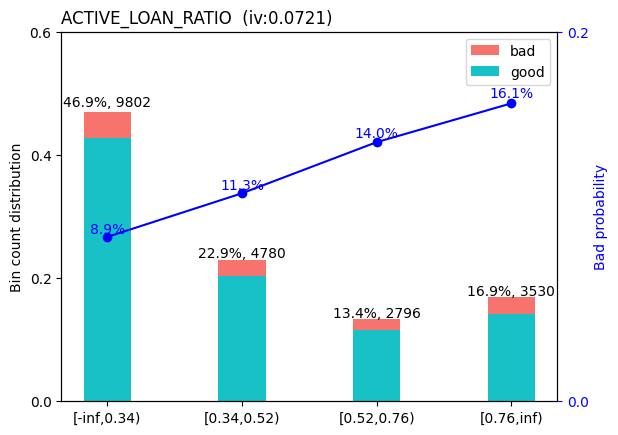

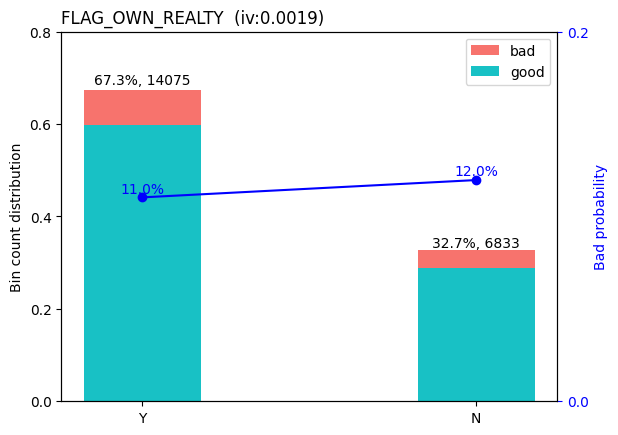

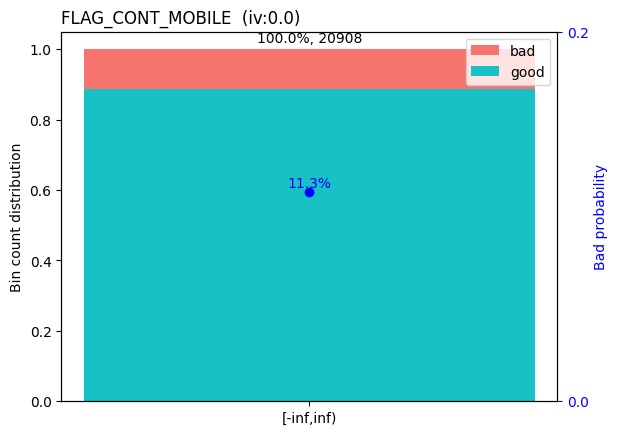

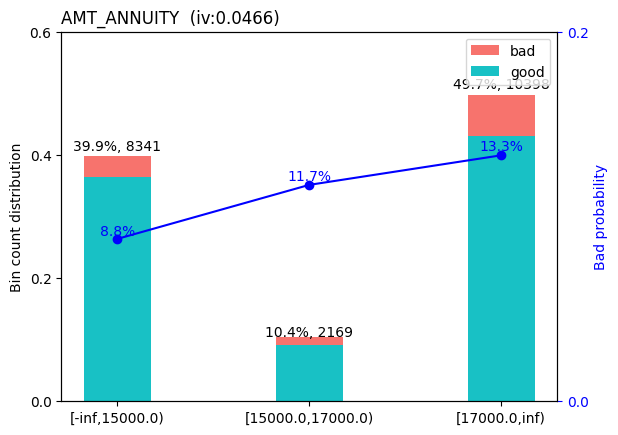

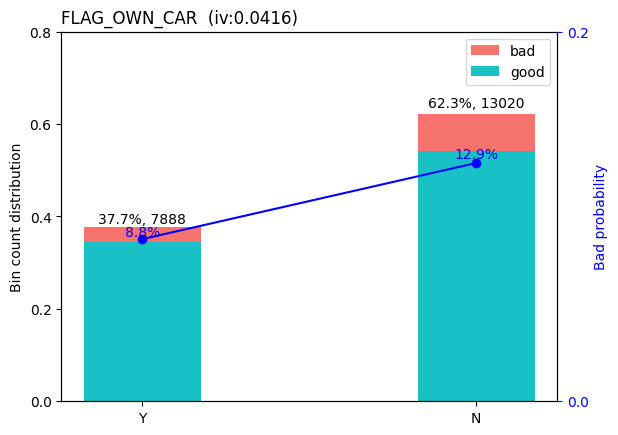

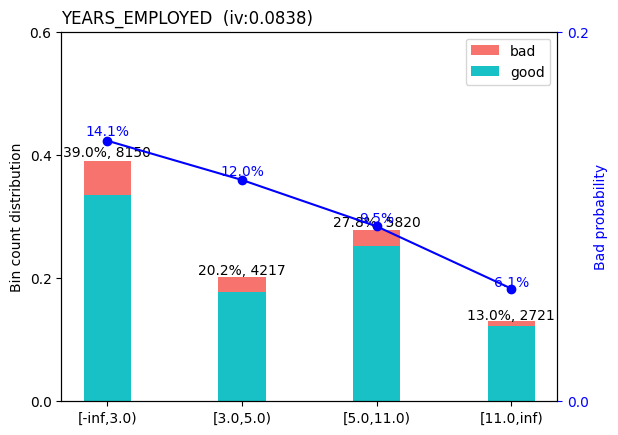

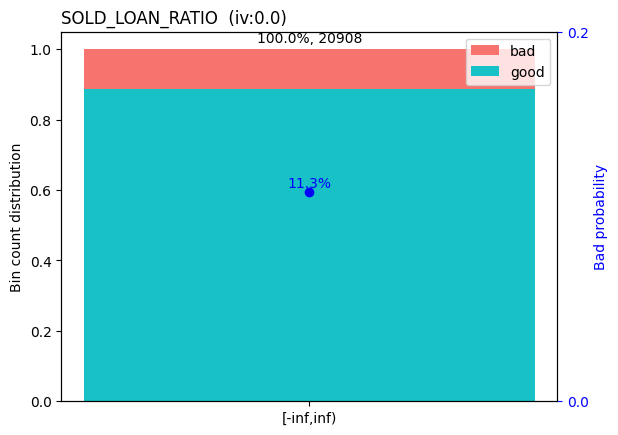

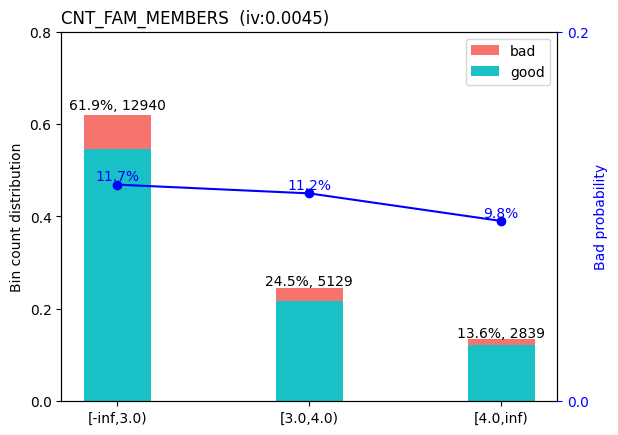

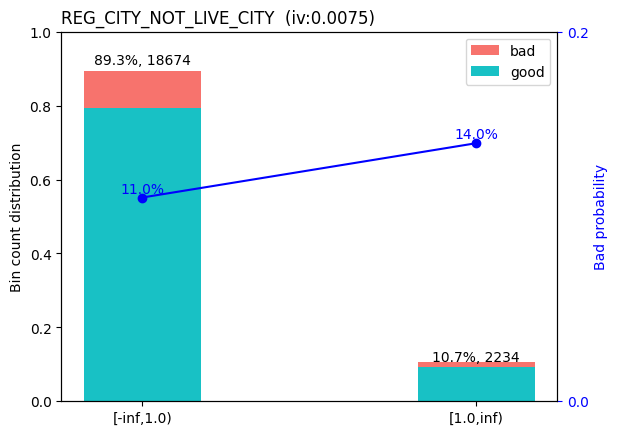

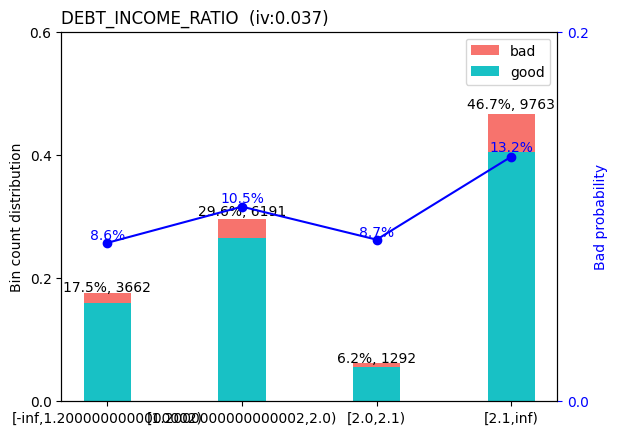

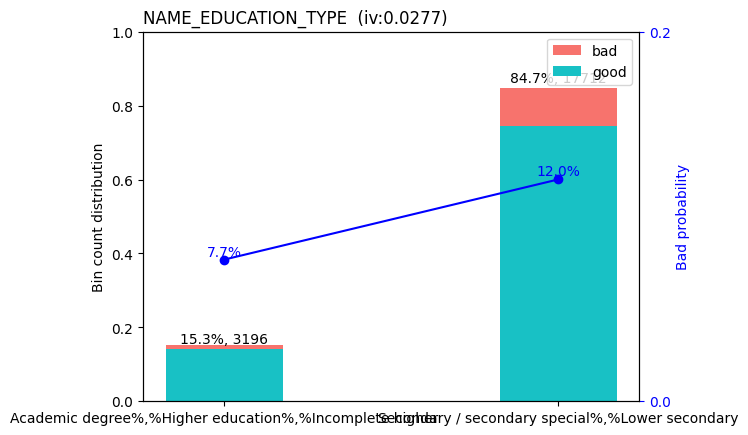

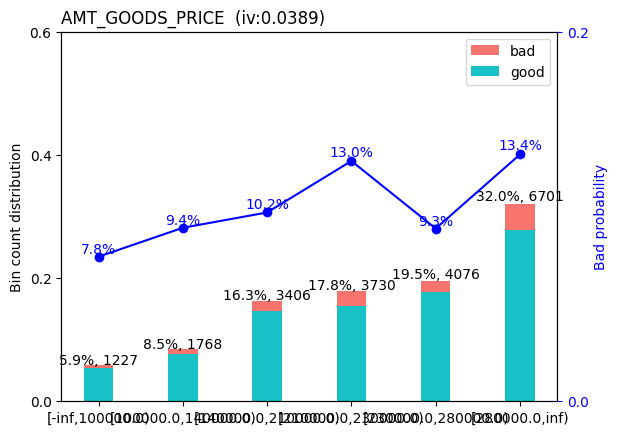

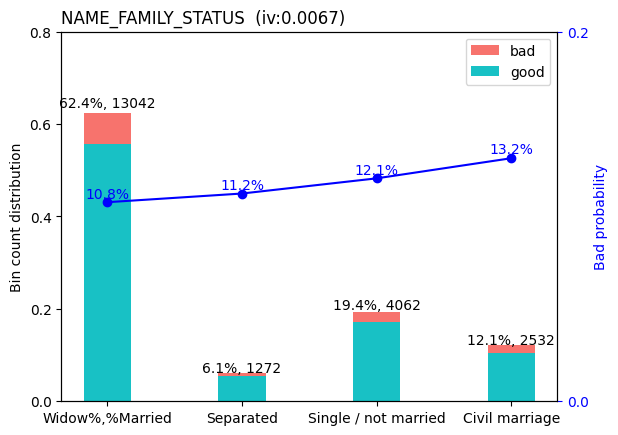

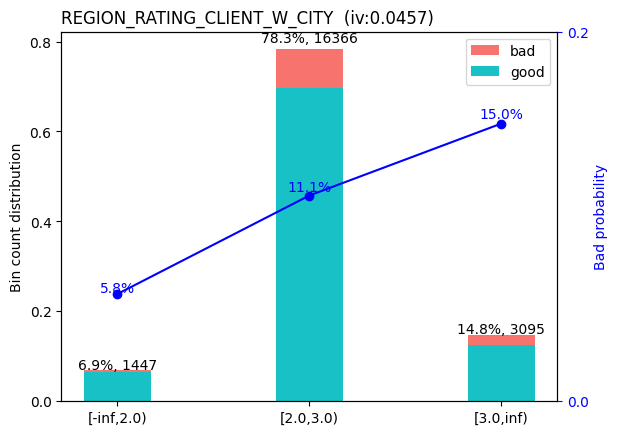

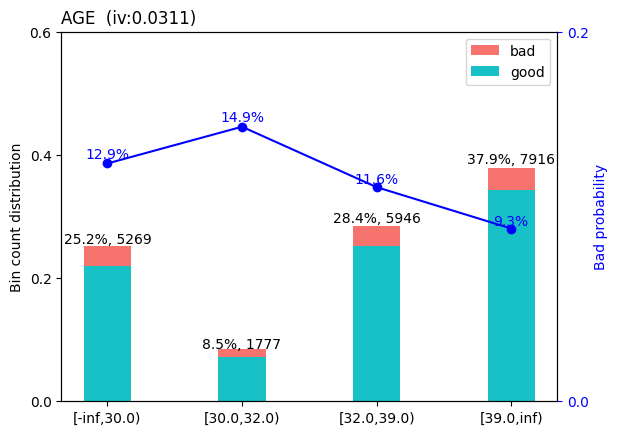

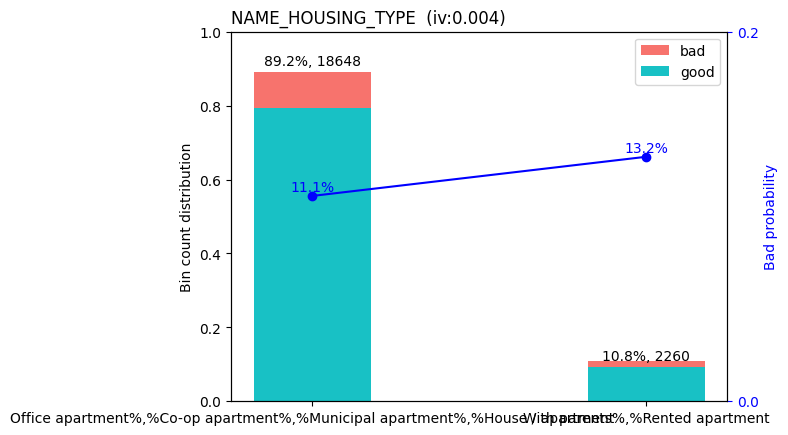

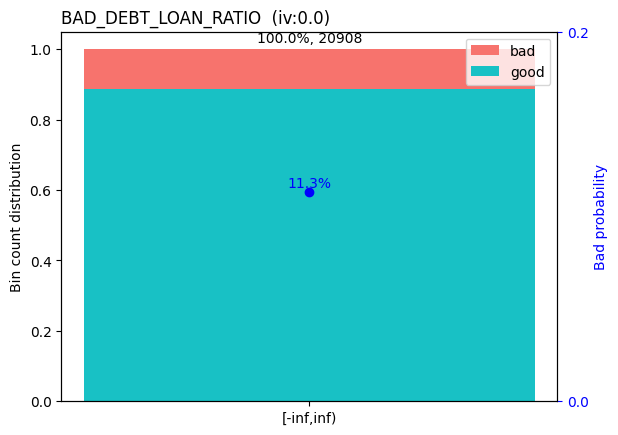

In [ ]:
sc.woebin_plot(bins)

## Characteristic Screening

### Drop columns with IV < 0.02 or >0.5
| Variable                          | IV    |
| --------------------------------- | ----- |
|AGE                            |   0.0288  |
|AMT_ANNUITY                    |   0.0473  |
|AMT_GOODS_PRICE                |   0.0348  |
|FLAG_OWN_CAR                   |   0.0371  |
|NAME_FAMILY_STATUS             |   0.0137  |
|AVG_CNT_CREDIT_PROLONG         |   0.0173  |
|NAME_HOUSING_TYPE              |   0.0039  |
|AVG_AMT_CREDIT_SUM_OVERDUE     |   0.0173  |
|CNT_FAM_MEMBERS                |   0.0080  |
|NAME_EDUCATION_TYPE            |   0.0254  |
|FLAG_CONT_MOBILE               |   0.0000  |
|DEBT_INCOME_RATIO              |   0.0392  |
|YEARS_EMPLOYED                 |   0.0836  |
|FLAG_OWN_REALTY                |   0.0015  |
|BAD_DEBT_LOAN_RATIO            |   0.0000  |
|SOLD_LOAN_RATIO                |   0.0000  |
|ACTIVE_LOAN_RATIO              |   0.0721  |
|REG_CITY_NOT_LIVE_CITY         |   0.0075  |
|AVG_CREDIT_DAY_OVERDUE         |   0.0000  |
|REGION_RATING_CLIENT_W_CITY    |   0.0457  |



In [ ]:
## Drop variable with IV < 0.02 or IV > 0.05
columns_to_drop = ["AVG_CNT_CREDIT_PROLONG",
                   "AVG_AMT_CREDIT_SUM_OVERDUE",
                    "NAME_FAMILY_STATUS",
                    "NAME_HOUSING_TYPE"	,
                    'FLAG_CONT_MOBILE',
                    'CNT_FAM_MEMBERS',
                    'FLAG_OWN_REALTY',
                    'YEARS_EMPLOYED',
                    "BAD_DEBT_LOAN_RATIO",
                    "SOLD_LOAN_RATIO",
                    "REG_CITY_NOT_LIVE_CITY",
                    "AVG_CREDIT_DAY_OVERDUE",
                ]
for col in columns_to_drop:
    merged_data.drop(col, axis=1, inplace=True)

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20908 entries, 0 to 20907
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TARGET                       20908 non-null  int64  
 1   AMT_ANNUITY                  20908 non-null  float64
 2   FLAG_OWN_CAR                 20908 non-null  object 
 3   AMT_GOODS_PRICE              20908 non-null  float64
 4   NAME_EDUCATION_TYPE          20908 non-null  object 
 5   REGION_RATING_CLIENT_W_CITY  20908 non-null  int64  
 6   AGE                          20908 non-null  float64
 7   ACTIVE_LOAN_RATIO            20908 non-null  float64
 8   DEBT_INCOME_RATIO            20908 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 1.4+ MB


## Coarse Classing

### Reviewing Motonicity

[INFO] creating woe binning ...
ACTIVE_LOAN_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ACTIVE_LOAN_RATIO,"[-inf,0.34)",9802,0.47,8930,872,0.09,-0.27,0.03,0.07,0.34,False
1,ACTIVE_LOAN_RATIO,"[0.34,0.52)",4780,0.23,4242,538,0.11,-0.01,0.00,0.07,0.52,False
2,ACTIVE_LOAN_RATIO,"[0.52,0.76)",2796,0.13,2404,392,0.14,0.24,0.01,0.07,0.76,False
3,ACTIVE_LOAN_RATIO,"[0.76,inf)",3530,0.17,2961,569,0.16,0.41,0.03,0.07,inf,False


----------------------------------------------------------------------------------------------------
AMT_GOODS_PRICE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_GOODS_PRICE,"[-inf,100000.0)",1227,0.06,1131,96,0.08,-0.41,0.01,0.04,100000.0,False
1,AMT_GOODS_PRICE,"[100000.0,140000.0)",1768,0.08,1602,166,0.09,-0.21,0.00,0.04,140000.0,False
2,AMT_GOODS_PRICE,"[140000.0,210000.0)",3406,0.16,3058,348,0.10,-0.12,0.00,0.04,210000.0,False
3,AMT_GOODS_PRICE,"[210000.0,230000.0)",3730,0.18,3245,485,0.13,0.16,0.00,0.04,230000.0,False
4,AMT_GOODS_PRICE,"[230000.0,280000.0)",4076,0.19,3695,381,0.09,-0.22,0.01,0.04,280000.0,False
5,AMT_GOODS_PRICE,"[280000.0,inf)",6701,0.32,5806,895,0.13,0.19,0.01,0.04,inf,False


----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY,"[-inf,15000.0)",8341,0.40,7608,733,0.09,-0.28,0.03,0.05,15000.0,False
1,AMT_ANNUITY,"[15000.0,17000.0)",2169,0.10,1915,254,0.12,0.04,0.00,0.05,17000.0,False
2,AMT_ANNUITY,"[17000.0,inf)",10398,0.50,9014,1384,0.13,0.18,0.02,0.05,inf,False


----------------------------------------------------------------------------------------------------
FLAG_OWN_CAR  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_OWN_CAR,Y,7888,0.38,7196,692,0.09,-0.29,0.03,0.04,Y,False
1,FLAG_OWN_CAR,N,13020,0.62,11341,1679,0.13,0.15,0.01,0.04,N,False


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT_W_CITY,"[-inf,2.0)",1447,0.07,1363,84,0.06,-0.73,0.03,0.05,2.0,False
1,REGION_RATING_CLIENT_W_CITY,"[2.0,3.0)",16366,0.78,14544,1822,0.11,-0.02,0.00,0.05,3.0,False
2,REGION_RATING_CLIENT_W_CITY,"[3.0,inf)",3095,0.15,2630,465,0.15,0.32,0.02,0.05,inf,False


----------------------------------------------------------------------------------------------------
AGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AGE,"[-inf,30.0)",5269,0.25,4591,678,0.13,0.14,0.01,0.03,30.0,False
1,AGE,"[30.0,32.0)",1777,0.08,1513,264,0.15,0.31,0.01,0.03,32.0,False
2,AGE,"[32.0,39.0)",5946,0.28,5257,689,0.12,0.02,0.00,0.03,39.0,False
3,AGE,"[39.0,inf)",7916,0.38,7176,740,0.09,-0.22,0.02,0.03,inf,False


----------------------------------------------------------------------------------------------------
DEBT_INCOME_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBT_INCOME_RATIO,"[-inf,1.2000000000000002)",3662,0.18,3348,314,0.09,-0.31,0.01,0.04,1.2000000000000002,False
1,DEBT_INCOME_RATIO,"[1.2000000000000002,2.0)",6191,0.30,5539,652,0.11,-0.08,0.00,0.04,2.0,False
2,DEBT_INCOME_RATIO,"[2.0,2.1)",1292,0.06,1179,113,0.09,-0.29,0.00,0.04,2.1,False
3,DEBT_INCOME_RATIO,"[2.1,inf)",9763,0.47,8471,1292,0.13,0.18,0.02,0.04,inf,False


----------------------------------------------------------------------------------------------------
NAME_EDUCATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_EDUCATION_TYPE,"Academic degree%,%Higher education%,%Incomplet...",3196,0.15,2951,245,0.08,-0.43,0.02,0.03,"Academic degree%,%Higher education%,%Incomplet...",False
1,NAME_EDUCATION_TYPE,"Secondary / secondary special%,%Lower secondary",17712,0.85,15586,2126,0.12,0.06,0.00,0.03,"Secondary / secondary special%,%Lower secondary",False


----------------------------------------------------------------------------------------------------


{'ACTIVE_LOAN_RATIO': <Figure size 640x480 with 2 Axes>,
 'AMT_GOODS_PRICE': <Figure size 640x480 with 2 Axes>,
 'AMT_ANNUITY': <Figure size 640x480 with 2 Axes>,
 'FLAG_OWN_CAR': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'AGE': <Figure size 640x480 with 2 Axes>,
 'DEBT_INCOME_RATIO': <Figure size 640x480 with 2 Axes>,
 'NAME_EDUCATION_TYPE': <Figure size 640x480 with 2 Axes>}

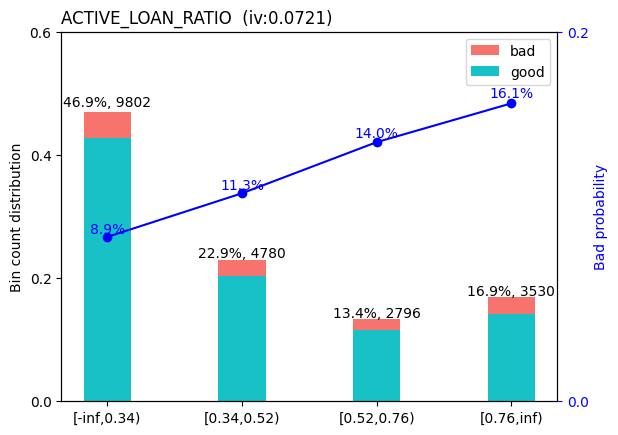

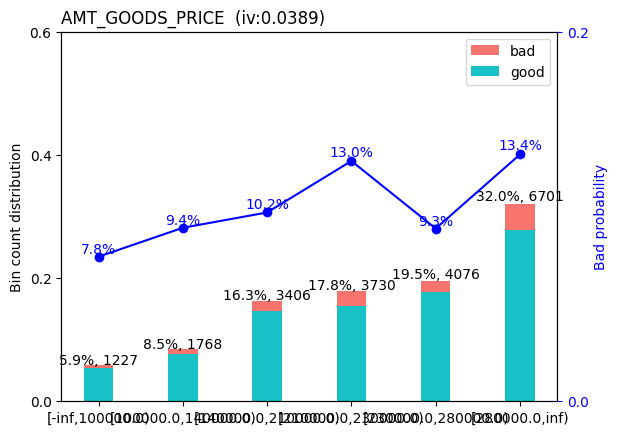

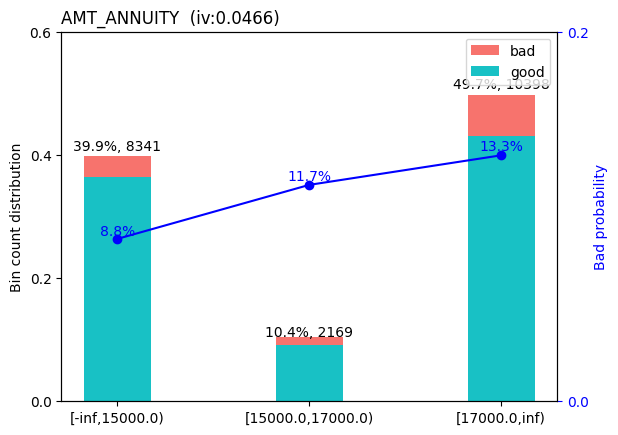

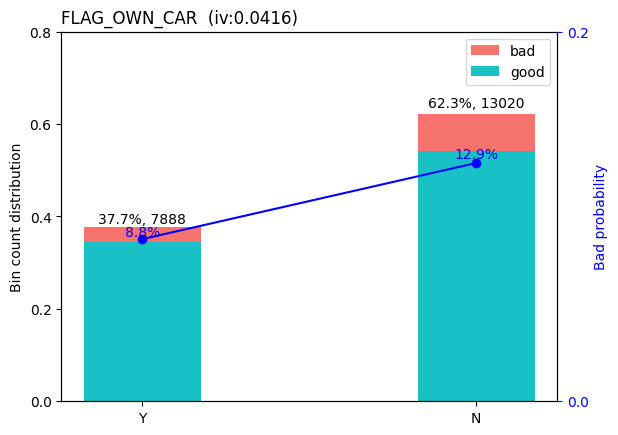

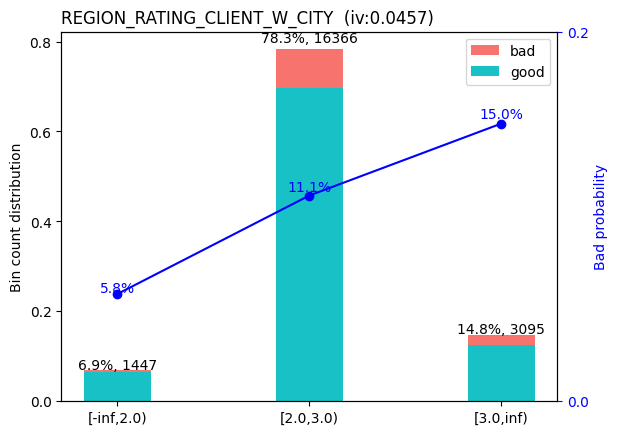

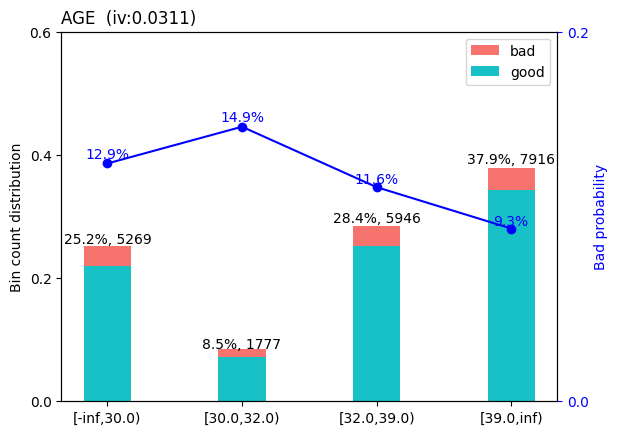

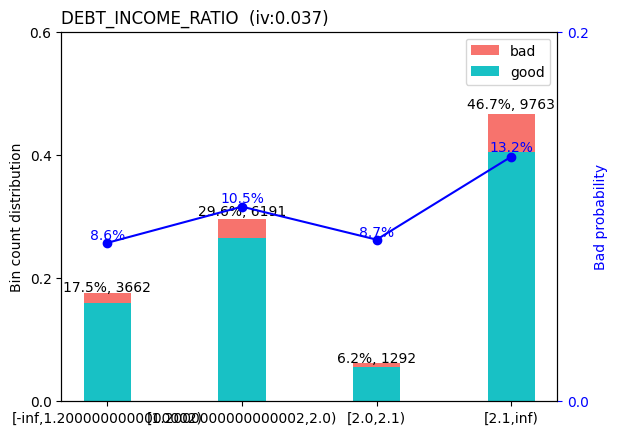

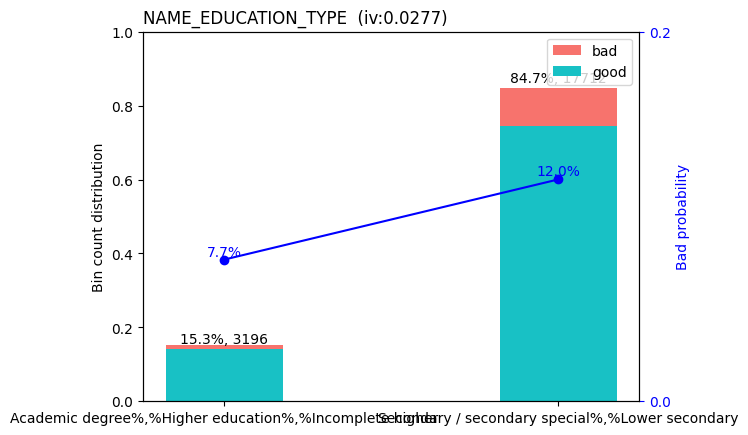

In [ ]:
bins_after_dropping_iv = sc.woebin(merged_data, y='TARGET')
for variables , bindetails in bins_after_dropping_iv.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

sc.woebin_plot(bins_after_dropping_iv)

### Manual adjustment of bins

[INFO] creating woe binning ...
ACTIVE_LOAN_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ACTIVE_LOAN_RATIO,"[-inf,0.34)",9802,0.47,8930,872,0.09,-0.27,0.03,0.07,0.34,False
1,ACTIVE_LOAN_RATIO,"[0.34,0.52)",4780,0.23,4242,538,0.11,-0.01,0.00,0.07,0.52,False
2,ACTIVE_LOAN_RATIO,"[0.52,0.76)",2796,0.13,2404,392,0.14,0.24,0.01,0.07,0.76,False
3,ACTIVE_LOAN_RATIO,"[0.76,inf)",3530,0.17,2961,569,0.16,0.41,0.03,0.07,inf,False


----------------------------------------------------------------------------------------------------
AMT_GOODS_PRICE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_GOODS_PRICE,"[-inf,100000.0)",1227,0.06,1131,96,0.08,-0.41,0.01,0.03,100000.0,False
1,AMT_GOODS_PRICE,"[100000.0,210000.0)",5174,0.25,4660,514,0.10,-0.15,0.01,0.03,210000.0,False
2,AMT_GOODS_PRICE,"[210000.0,280000.0)",7806,0.37,6940,866,0.11,-0.02,0.00,0.03,280000.0,False
3,AMT_GOODS_PRICE,"[280000.0,inf)",6701,0.32,5806,895,0.13,0.19,0.01,0.03,inf,False


----------------------------------------------------------------------------------------------------
AMT_ANNUITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY,"[-inf,15000.0)",8341,0.40,7608,733,0.09,-0.28,0.03,0.05,15000.0,False
1,AMT_ANNUITY,"[15000.0,17000.0)",2169,0.10,1915,254,0.12,0.04,0.00,0.05,17000.0,False
2,AMT_ANNUITY,"[17000.0,20000.0)",2568,0.12,2231,337,0.13,0.17,0.00,0.05,20000.0,False
3,AMT_ANNUITY,"[20000.0,inf)",7830,0.37,6783,1047,0.13,0.19,0.01,0.05,inf,False


----------------------------------------------------------------------------------------------------
FLAG_OWN_CAR  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_OWN_CAR,Y,7888,0.38,7196,692,0.09,-0.29,0.03,0.04,Y,False
1,FLAG_OWN_CAR,N,13020,0.62,11341,1679,0.13,0.15,0.01,0.04,N,False


----------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT_W_CITY,"[-inf,2.0)",1447,0.07,1363,84,0.06,-0.73,0.03,0.05,2.0,False
1,REGION_RATING_CLIENT_W_CITY,"[2.0,3.0)",16366,0.78,14544,1822,0.11,-0.02,0.00,0.05,3.0,False
2,REGION_RATING_CLIENT_W_CITY,"[3.0,inf)",3095,0.15,2630,465,0.15,0.32,0.02,0.05,inf,False


----------------------------------------------------------------------------------------------------
AGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AGE,"[-inf,30.0)",5269,0.25,4591,678,0.13,0.14,0.01,0.02,30.0,False
1,AGE,"[30.0,40.0)",8529,0.41,7502,1027,0.12,0.07,0.00,0.02,40.0,False
2,AGE,"[40.0,inf)",7110,0.34,6444,666,0.09,-0.21,0.01,0.02,inf,False


----------------------------------------------------------------------------------------------------
DEBT_INCOME_RATIO  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBT_INCOME_RATIO,"[-inf,1.2)",3450,0.17,3147,303,0.09,-0.28,0.01,0.02,1.2,False
1,DEBT_INCOME_RATIO,"[1.2,2.0)",6403,0.31,5740,663,0.10,-0.10,0.00,0.02,2.0,False
2,DEBT_INCOME_RATIO,"[2.0,inf)",11055,0.53,9650,1405,0.13,0.13,0.01,0.02,inf,False


----------------------------------------------------------------------------------------------------
NAME_EDUCATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_EDUCATION_TYPE,"Academic degree%,%Higher education%,%Incomplet...",3196,0.15,2951,245,0.08,-0.43,0.02,0.03,"Academic degree%,%Higher education%,%Incomplet...",False
1,NAME_EDUCATION_TYPE,"Secondary / secondary special%,%Lower secondary",17712,0.85,15586,2126,0.12,0.06,0.00,0.03,"Secondary / secondary special%,%Lower secondary",False


----------------------------------------------------------------------------------------------------


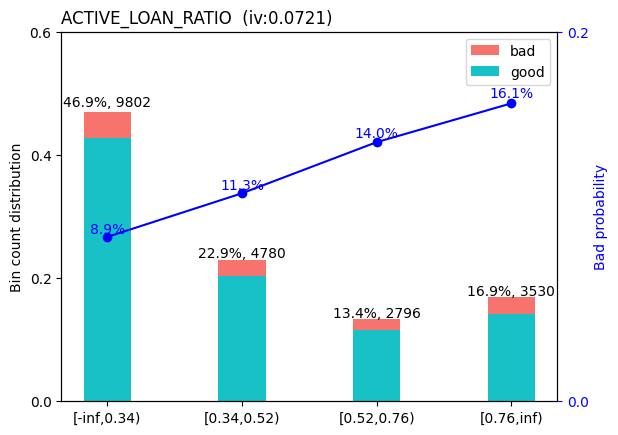

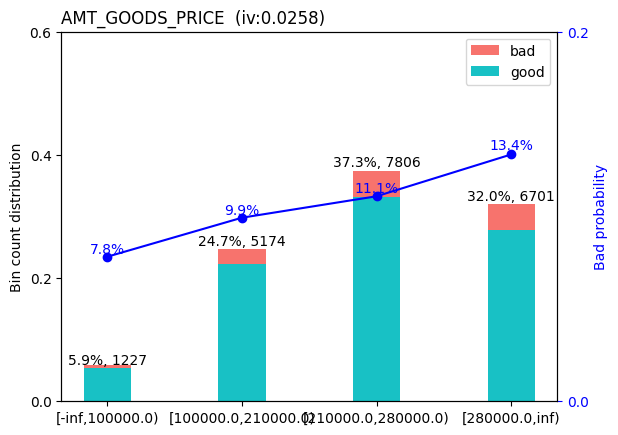

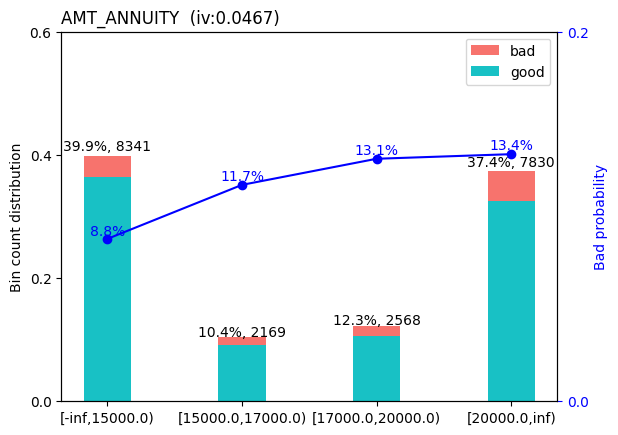

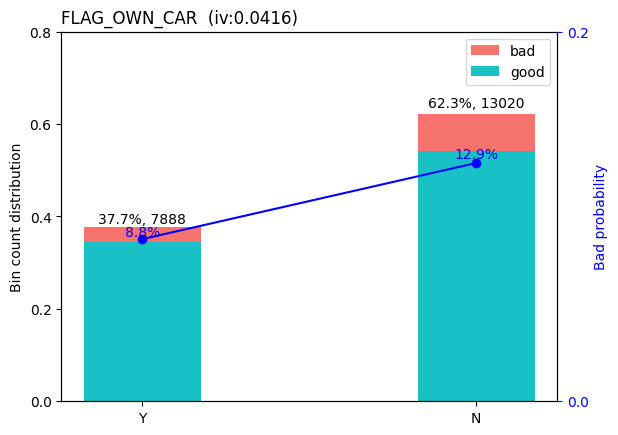

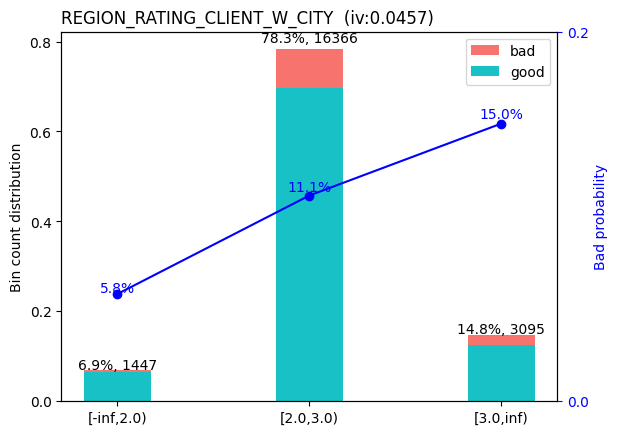

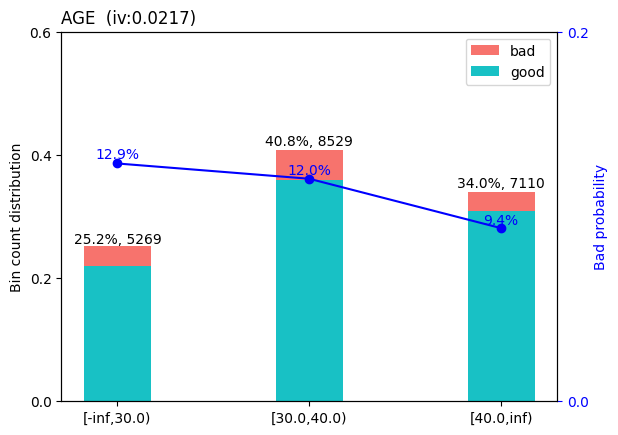

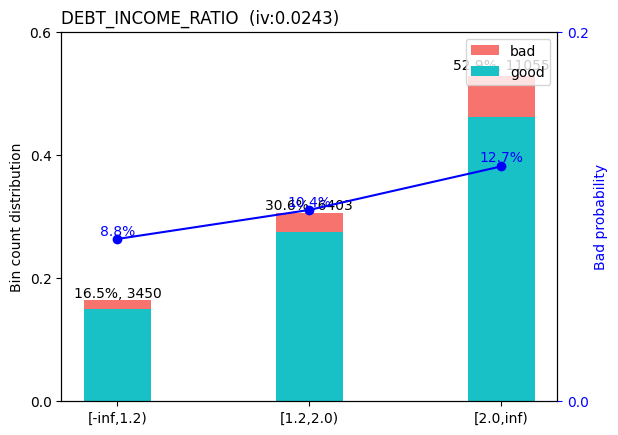

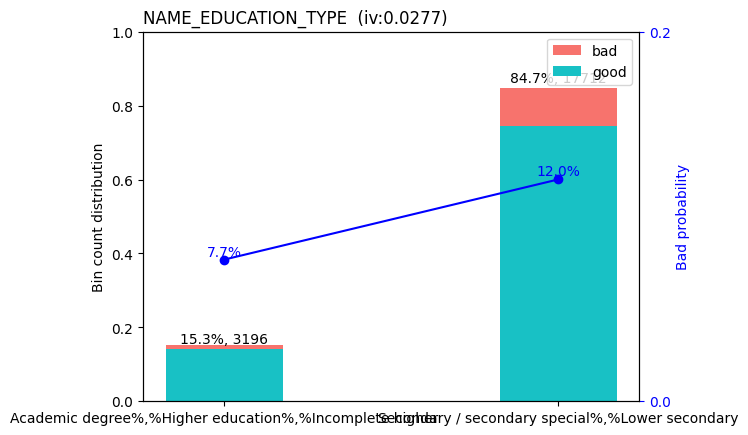

In [ ]:
# bin adjustments

breaks_adj = {
            'DEBT_INCOME_RATIO' : [1.2, 2.0],
            'AMT_ANNUITY' : [15000.0, 17000.0, 20000.0],
            'AGE': [30.0, 40.0],
            'AMT_GOODS_PRICE':[100000.0, 210000.0, 280000.0],
            }

bins2 = sc.woebin(merged_data, y='TARGET',breaks_list=breaks_adj)
sc.woebin_plot(bins2)

for variables , bindetails in bins2.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

| Variable                   |  Previous IV |   New IV     |
|---------------------------|-----------|-----------------|      
| NAME_EDUCATION_TYPE              | 0.0227    |   0.0227 |
| AMT_GOODS_PRICE   | 0.0389    |   0.0258 |
| AGE        | 0.0311    |   0.0217 |
| ACTIVE_LOAN_RATIO             | 0.0721    |   0.0721 |
| FLAG_OWN_CAR         | 0.0416    |   0.0416 |
| DEBT_INCOME_RATIO | 0.0370   |   0.0243 |
| AMT_ANNUITY             | 0.0466    |   0.0467 |
| REGION_RATING_CLIENT_W_CITY            | 0.0457   |   0.0457 |


# Create Scorecard

|   |Characteristic         |              Number of Attributes |  IV |  
|--- |  ------               |        --------------  | ----- |  
|   1   |   NAME_EDUCATION_TYPE               |   2   |   0.0227  |
|   2   |  AMT_GOODS_PRICE                 |   4   |   0.0258  |
|   3   |  AGE          |   3   |   0.0217  |
|   4   |   ACTIVE_LOAN_RATIO  |   4   |   0.0721  |
|   5   |  FLAG_OWN_CAR                  |   2   |   0.0416  |
|   6   |  DEBT_INCOME_RATIO             |   3   |   0.0243  |
|   7   |  AMT_ANNUITY  |   4   |   0.0467  |  
|   8   |  REGION_RATING_CLIENT_W_CITY                 |   3   |   0.0457  |


## Logistic Regression with WOE Encoding

In [64]:
# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
woe_merged_data = sc.woebin_ply(merged_data,bins2)
woe_merged_data

[INFO] converting into woe values ...


,TARGET,ACTIVE_LOAN_RATIO_woe,AMT_GOODS_PRICE_woe,AMT_ANNUITY_woe,FLAG_OWN_CAR_woe,REGION_RATING_CLIENT_W_CITY_woe,AGE_woe,DEBT_INCOME_RATIO_woe,NAME_EDUCATION_TYPE_woe
0,1,-0.27,0.19,0.19,0.15,-0.02,0.14,0.13,0.06
1,0,-0.27,0.19,0.19,0.15,-0.02,-0.21,0.13,0.06
2,0,0.24,-0.41,-0.28,0.15,-0.02,0.07,-0.10,0.06
3,0,0.41,-0.02,0.19,-0.29,0.32,0.14,-0.10,0.06
4,0,0.41,-0.15,-0.28,0.15,-0.73,-0.21,-0.10,0.06
...,...,...,...,...,...,...,...,...,...
20903,1,-0.01,0.19,0.19,0.15,0.32,0.07,0.13,0.06
20904,1,-0.01,0.19,0.19,0.15,0.32,0.14,0.13,0.06
20905,0,-0.27,-0.15,-0.28,0.15,-0.02,0.14,-0.10,-0.43
20906,0,-0.27,-0.02,-0.28,0.15,-0.02,-0.21,0.13,0.06


In [65]:
train_woe, test_woe = sc.split_df(woe_merged_data, 'TARGET', ratio=0.7).values()
print(train_woe.shape)
print(test_woe.shape)

(14636, 9)
(6272, 9)


In [66]:
#create the X, y parts of data for train and test
y_train = train_woe.loc[:,'TARGET']
X_train = train_woe.loc[:,train_woe.columns != 'TARGET']
y_test = test_woe.loc[:,'TARGET']
X_test = test_woe.loc[:,train_woe.columns != 'TARGET']

In [67]:
X_train.head()

,ACTIVE_LOAN_RATIO_woe,AMT_GOODS_PRICE_woe,AMT_ANNUITY_woe,FLAG_OWN_CAR_woe,REGION_RATING_CLIENT_W_CITY_woe,AGE_woe,DEBT_INCOME_RATIO_woe,NAME_EDUCATION_TYPE_woe
0,-0.27,0.19,0.19,0.15,-0.02,0.14,0.13,0.06
1,-0.27,0.19,0.19,0.15,-0.02,-0.21,0.13,0.06
4,0.41,-0.15,-0.28,0.15,-0.73,-0.21,-0.10,0.06
5,-0.27,-0.02,0.19,0.15,-0.02,-0.21,0.13,0.06
7,-0.27,-0.02,-0.28,0.15,-0.02,-0.21,-0.10,0.06


In [68]:
#create a logistic regression model object
lr = LogisticRegression(random_state=42, class_weight='balanced')

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Logistic regression coef:\n ",lr.coef_,"\n")
print("\nLogistic regression intercept: ",lr.intercept_,"\n")
print("\nLogistic regression accuracy: ",accuracy_score(y_test,y_pred),"\n")
print(10*"*","Percentage Correctly Classified",10*"*","\n",classification_report(y_test, y_pred))

Logistic regression coef:
  [[1.03689469 0.1661396  0.90811857 1.08207791 0.994331   1.00988355
  0.28588051 0.81999075]] 


Logistic regression intercept:  [0.0046861] 


Logistic regression accuracy:  0.5845025510204082 

********** Percentage Correctly Classified ********** 
               precision    recall  f1-score   support

           0       0.92      0.58      0.71      5561
           1       0.16      0.62      0.25       711

    accuracy                           0.58      6272
   macro avg       0.54      0.60      0.48      6272
weighted avg       0.84      0.58      0.66      6272



## Generate Scorecard

In [69]:
print(X_train.columns)

Index(['ACTIVE_LOAN_RATIO_woe', 'AMT_GOODS_PRICE_woe', 'AMT_ANNUITY_woe',
       'FLAG_OWN_CAR_woe', 'REGION_RATING_CLIENT_W_CITY_woe', 'AGE_woe',
       'DEBT_INCOME_RATIO_woe', 'NAME_EDUCATION_TYPE_woe'],
      dtype='object')


In [75]:
card = sc.scorecard(
        bins2,
        lr,
        X_train.columns,
        points0 = 600,
        odds0 = 1/20,
        pdo = 50,
        basepoints_eq0 = False
        )

pprint.pprint(card)

{'ACTIVE_LOAN_RATIO':             variable          bin  points
0  ACTIVE_LOAN_RATIO  [-inf,0.34)   20.00
1  ACTIVE_LOAN_RATIO  [0.34,0.52)    1.00
2  ACTIVE_LOAN_RATIO  [0.52,0.76)  -18.00
3  ACTIVE_LOAN_RATIO   [0.76,inf)  -30.00,
 'AGE':    variable          bin  points
17      AGE  [-inf,30.0)  -10.00
18      AGE  [30.0,40.0)   -5.00
19      AGE   [40.0,inf)   16.00,
 'AMT_ANNUITY':        variable                bin  points
8   AMT_ANNUITY     [-inf,15000.0)   19.00
9   AMT_ANNUITY  [15000.0,17000.0)   -2.00
10  AMT_ANNUITY  [17000.0,20000.0)  -11.00
11  AMT_ANNUITY      [20000.0,inf)  -12.00,
 'AMT_GOODS_PRICE':           variable                  bin  points
4  AMT_GOODS_PRICE      [-inf,100000.0)    5.00
5  AMT_GOODS_PRICE  [100000.0,210000.0)    2.00
6  AMT_GOODS_PRICE  [210000.0,280000.0)    0.00
7  AMT_GOODS_PRICE       [280000.0,inf)   -2.00,
 'DEBT_INCOME_RATIO':              variable         bin  points
20  DEBT_INCOME_RATIO  [-inf,1.2)    6.00
21  DEBT_INCOME_RATIO   [1.

## Test scorecard

#### Approval (>= 550)
Variable | Value
--- | ---
ACTIVE_LOAN_RATIO | 0.30
AGE | 40.0
AMT_ANNUITY | 10000.0
AMT_GOODS_PRICE |90000.0
DEBT_INCOME_RATIO | 1.0
FLAG_OWN_CAR | Y
NAME_EDUCATION_TYPE | Academic degree
REGION_RATING_CLIENT_W_CITY | 1.0



In [76]:
variable_names = ['ACTIVE_LOAN_RATIO', 'AGE', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DEBT_INCOME_RATIO', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE', 'REGION_RATING_CLIENT_W_CITY']
value= [[0.30, 40.0, 10000.0, 90000.0, 1.0, 'Y', 'Academic degree', 1.0]]
new_application = pd.DataFrame(value, columns = variable_names)
new_application_score = sc.scorecard_ply(new_application, card, only_total_score=False).transpose()
new_application_score.index = new_application_score.index.str.replace('_points', '')
summary =  pd.concat([new_application.transpose(), new_application_score], axis=1)
summary.columns = ['Applicaton Value','Points']
print(summary)

                            Applicaton Value  Points
ACTIVE_LOAN_RATIO                       0.30   20.00
AGE                                    40.00   16.00
AMT_ANNUITY                         10000.00   19.00
AMT_GOODS_PRICE                     90000.00    5.00
DEBT_INCOME_RATIO                       1.00    6.00
FLAG_OWN_CAR                               Y   22.00
NAME_EDUCATION_TYPE          Academic degree   26.00
REGION_RATING_CLIENT_W_CITY             1.00   52.00
score                                    NaN  550.00


#### Rejection (< 550)
Variable | Value
--- | ---
ACTIVE_LOAN_RATIO | 0.60
AGE | 30.0
AMT_ANNUITY | 17000.0
AMT_GOODS_PRICE | 220000.0
DEBT_INCOME_RATIO | 2.1
FLAG_OWN_CAR | N
NAME_EDUCATION_TYPE | Secondary / secondary special
REGION_RATING_CLIENT_W_CITY | 3.0

In [77]:
variable_names = ['ACTIVE_LOAN_RATIO', 'AGE', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DEBT_INCOME_RATIO', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE', 'REGION_RATING_CLIENT_W_CITY']
value= [[0.60, 30.0, 17000.0, 220000.0, 2.1, 'N', 'Secondary / secondary special', 3.0]]
new_application = pd.DataFrame(value, columns = variable_names)
new_application_score = sc.scorecard_ply(new_application, card, only_total_score=False).transpose()
new_application_score.index = new_application_score.index.str.replace('_points', '')
summary =  pd.concat([new_application.transpose(), new_application_score], axis=1)
summary.columns = ['Applicaton Value','Points']
print(summary)

                                          Applicaton Value  Points
ACTIVE_LOAN_RATIO                                     0.60  -18.00
AGE                                                  30.00   -5.00
AMT_ANNUITY                                       17000.00  -11.00
AMT_GOODS_PRICE                                  220000.00    0.00
DEBT_INCOME_RATIO                                     2.10   -3.00
FLAG_OWN_CAR                                             N  -11.00
NAME_EDUCATION_TYPE          Secondary / secondary special   -4.00
REGION_RATING_CLIENT_W_CITY                           3.00  -23.00
score                                                  NaN  309.00


# Analysis and Tuning

## Analysis of current scorecard

In [78]:
train_woe.head()

,TARGET,ACTIVE_LOAN_RATIO_woe,AMT_GOODS_PRICE_woe,AMT_ANNUITY_woe,FLAG_OWN_CAR_woe,REGION_RATING_CLIENT_W_CITY_woe,AGE_woe,DEBT_INCOME_RATIO_woe,NAME_EDUCATION_TYPE_woe
0,1,-0.27,0.19,0.19,0.15,-0.02,0.14,0.13,0.06
1,0,-0.27,0.19,0.19,0.15,-0.02,-0.21,0.13,0.06
4,0,0.41,-0.15,-0.28,0.15,-0.73,-0.21,-0.10,0.06
5,0,-0.27,-0.02,0.19,0.15,-0.02,-0.21,0.13,0.06
7,0,-0.27,-0.02,-0.28,0.15,-0.02,-0.21,-0.10,0.06


In [80]:
# train_score = sc.scorecard_ply(train_woe, card)
# test_score = sc.scorecard_ply(test_woe, card)

# If 'card' does not have '_woe' in the column names, add them
card_woe_columns = {k + '_woe': v for k, v in card.items() if '_woe' not in k}

# Now use the updated 'card_woe_columns' in the 'scorecard_ply' function
train_score = sc.scorecard_ply(train_woe, card_woe_columns)
test_score = sc.scorecard_ply(test_woe, card_woe_columns)


#distribution of scores on test data
train_score.hist(figsize=(7,5),bins=60)
plt.title('train data scores')
test_score.hist(figsize=(7,5),bins=60)
plt.title('test data scores')

KeyError: "None of [Index(['ACTIVE_LOAN_RATIO'], dtype='object')] are in the [columns]"

### Confusion Matrix

In [ ]:
tp,fp,fn,tn = confusion_matrix(y_test, y_pred).ravel()
print("\n******* Confusion Matrix Metrics (Untuned) *******")
print("True Positive: ",tp)
print("False Positive: ",fp)
print("False Negative: ",fn)
print("True Negative: ",tn)
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("\n")
print(classification_report(y_test, y_pred))

### Credit scores for samples

In [ ]:
# evaluate the performance of the logistic regression
train_pred= lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# performance ks & roc
train_perf = sc.perf_eva(y_train, train_pred, plot_type=['roc'], title = "train")
test_perf = sc.perf_eva(y_test, test_pred, plot_type=['roc'], title = "test")


## Tuning of the current scorecard


In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag']
}

# Initialize the grid search with a LogisticRegression estimator, the defined parameter grid, and the stratified CV
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42),
                           param_grid, scoring='roc_auc', verbose=2)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding AUC score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best AUC score: {grid_search.best_score_}")

# Retrain the model using the best parameters found
tuned_lr = LogisticRegression(
    C=grid_search.best_params_['C'],
    penalty=grid_search.best_params_['penalty'],
    solver=grid_search.best_params_['solver'],
    class_weight='balanced',
    random_state=42
)
tuned_lr.fit(X_train, y_train)

new_card = sc.scorecard(
        bins,
        tuned_lr,
        X_train.columns,
        points0 = 600,
        odds0 = 1/20,
        pdo = 20,
        basepoints_eq0 = False
    )

y_pred_tuned = tuned_lr.predict(X_test)

print("Logistic regression coef:\n ",lr.coef_,"\n")
print("\nLogistic regression intercept: ",lr.intercept_,"\n")

In [ ]:
tp,fp,fn,tn = confusion_matrix(y_test, y_pred_tuned).ravel()
print("\n******* Confusion Matrix Metrics (Tuned) *******")
print("True Positive: ",tp)
print("False Positive: ",fp)
print("False Negative: ",fn)
print("True Negative: ",tn)
print("Accuracy: ",accuracy_score(y_test,y_pred_tuned))
print("\n")
print(classification_report(y_test, y_pred_tuned))

In [ ]:
train_score = sc.scorecard_ply(train, new_card)
test_score = sc.scorecard_ply(test, new_card)

#distribution of scores on test data
train_score.hist(figsize=(7,5),bins=60)
plt.title('tuned train data scores')
test_score.hist(figsize=(7,5),bins=60)
plt.title('tuned test data scores')

In [ ]:
# evaluate the performance of the logistic regression
train_tuned_pred= tuned_lr.predict_proba(X_train)[:,1]
test_tuned_pred = tuned_lr.predict_proba(X_test)[:,1]

# performance ks & roc
train_perf_tuned = sc.perf_eva(y_train, train_tuned_pred, plot_type=['roc'], title = "train_tuned")
test_perf_tuned = sc.perf_eva(y_test, test_tuned_pred, plot_type=['roc'], title = "test_tuned")
